# BA2023-Regression
[BA2023 class competition](https://www.kaggle.com/competitions/ba2023-regression/overview).

### Description
Within the context of Eleme delivery service, at every moment the command platform of “Smart Logistics” sends orders from customers to delivery-men for instant delivery. The decisions being made by the delivery-men are mainly two-fold: (i) pick-up from a store, and delivery to a customer. At any specific moment, a delivery-man may receive new orders assigned to him, while he has some unfinished orders which were previously assigned. In this situation, he needs to decide what to do next (to pick up a new order or to deliver an old one), based on his order status and geographical location.

There are two main tasks for this project, each counting 5% towards your final course grade. The first task is a classification problem, in which you are asked to build a model to predict whether the delivery-man’s next move is to pick up an order or to deliver an order. The second task is a regression problem, in which you are asked to build a model to predict the expected time of the delivery-man's next action. For both tasks, you will use his historical decisions and current status as features. For each task, you need to submit a CSV file in the same format as the sample to the corresponding Kaggle competition.

The submission to the classification problem should be in 0–1 format, with 1 representing the “DELIVERY” action. The data has been preprocessed, but you should decide your own approach to the problem: Which features to use, what models to try, how to deal with outliers, etc.

Besides submitting your prediction results to Kaggle, you are also required to submit a PDF explaining your ideas and solution approach, together with the Jupyter Notebook with the computational results. This will be MORE important than your Kaggle score to determine your grade.

##### Evaluation
The evaluation metric for this competition is MAE-Score

### Variables
- `courier_id`, `wave_index`, `tracking_id`, `date`, `group`, `id` - These are the demographic information of the order and its courier. The column names are somewhat self-explanatory.
- `courier_wave_start_lng`, `courier_wave_start_lat` - These are the starting longitude and latitude of that wave of a certain courier.
- `level`, `speed`, `max_load` - These are the courier information: The level of the courier, the speed of the courier and the max load of the courier.
- `weather_grade` - This is the weather condition of the order.
- `aoi_id` - The id of the Area of Interest (i.e., the delivery destination).
- `shop_id` - The id of the shop.
- `source_type`, `source_tracking_id`, `source_lng`, `source_lat` - The information of the courier’s previous action.
- `target_lng`, `target_lat` - The geographical information of the target.
- `grid_distance` - The shortest traversable distance to the target provided by the GPS.
- `hour` - The hour in the day.
- `urgency` - Identifies how urgent the order is
- `action_type` - The outcome variable in the classification task. This is masked in the test set.
- `expected_use_time` - The outcome variable in the regression task. This is also masked in the test set

Finally, we want to remind you that NOT ALL VARIABLES ARE NECESSARILY NEEDED. So, you should use your own judgment to decide what to use for your model.

### Load the Workspace

In [1]:
import re
import datetime as dt
import warnings
import zipfile
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE, SelectKBest, f_classif, f_regression

from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import tensorflow as tf

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.metrics import mean_absolute_error

### Load the Data

In [2]:
def list_files_in_zip(zip_file_path):
    zip_files = list()
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        for file in file_list:
            zip_files.append(file)
    return zip_files

def read_csv_from_zip(zip_file_path, csv_file_name):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(csv_file_name) as file:
            df = pd.read_csv(io.TextIOWrapper(file))
            return df

In [3]:
zip_file_path = 'ba2023-regression.zip'

ba2023_files = list_files_in_zip(zip_file_path)
ba2023_files

['dataframe_test.csv',
 'dataframe_train.csv',
 'questions_project.pdf',
 'regression_example.csv']

In [4]:
train = read_csv_from_zip(zip_file_path, ba2023_files[1])
train.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,action_type,date,group,level,speed,...,source_type,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour
0,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,...,ASSIGN,2.100070e+18,121.630997,39.142343,121.632547,39.141946,377.0,804,1246,11
1,10007871,0,2.100070e+18,121.630997,39.142343,DELIVERY,20200201,2.020020e+16,3,4.751832,...,PICKUP,2.100070e+18,121.632547,39.141946,121.626144,39.140281,780.0,298,1246,11
2,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,...,DELIVERY,2.100070e+18,121.626144,39.140281,121.631219,39.141811,550.0,545,2462,11
3,10007871,0,2.100070e+18,121.630997,39.142343,DELIVERY,20200201,2.020020e+16,3,4.751832,...,PICKUP,2.100070e+18,121.631219,39.141811,121.632084,39.146201,707.0,341,1205,11
4,10007871,0,2.100070e+18,121.630997,39.142343,PICKUP,20200201,2.020020e+16,3,4.751832,...,DELIVERY,2.100070e+18,121.632084,39.146201,121.631574,39.142231,770.0,166,1882,11


In [5]:
test = read_csv_from_zip(zip_file_path, ba2023_files[0])
test.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,date,group,level,speed,max_load,...,id,source_type,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,urgency,hour
0,10007871,2,2.100000e+18,121.630558,39.1409,20200228,2.020000e+16,3,5.535851,11,...,509790,ASSIGN,2.10E+18,121.630558,39.140900,121.629930,39.144603,796.0,1776,13
1,10007871,2,2.100000e+18,121.630558,39.1409,20200228,2.020000e+16,3,5.535851,11,...,509791,PICKUP,2.10E+18,121.629930,39.144603,121.629604,39.150661,1048.0,697,13
2,10007871,2,2.100000e+18,121.630558,39.1409,20200228,2.020000e+16,3,5.535851,11,...,509792,DELIVERY,2.10E+18,121.629604,39.150661,121.629930,39.144603,1019.0,1756,13
3,10007871,2,2.100000e+18,121.630558,39.1409,20200228,2.020000e+16,3,5.535851,11,...,509793,PICKUP,2.10E+18,121.629930,39.144603,121.630544,39.152711,1198.0,676,13
4,10007871,2,2.100000e+18,121.630558,39.1409,20200228,2.020000e+16,3,5.535851,11,...,509794,DELIVERY,2.10E+18,121.630544,39.152711,121.631446,39.142762,1275.0,2336,14


In [6]:
sample_sub = read_csv_from_zip(zip_file_path, ba2023_files[3])
sample_sub.head()

,order,expected_use_time
0,0,100
1,1,100
2,2,100
3,3,100
4,4,100


### Data Cleaning

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509604 entries, 0 to 509603
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   courier_id              509604 non-null  int64  
 1   wave_index              509604 non-null  int64  
 2   tracking_id             509604 non-null  float64
 3   courier_wave_start_lng  509604 non-null  float64
 4   courier_wave_start_lat  509604 non-null  float64
 5   action_type             509604 non-null  object 
 6   date                    509604 non-null  int64  
 7   group                   509604 non-null  float64
 8   level                   509604 non-null  int64  
 9   speed                   509604 non-null  float64
 10  max_load                509604 non-null  int64  
 11  weather_grade           509604 non-null  object 
 12  aoi_id                  509604 non-null  object 
 13  shop_id                 509604 non-null  object 
 14  id                  

How many unique values are in each feature:

In [8]:
for col in train.columns:
    print(col, ":", train[col].nunique())

courier_id : 979
wave_index : 17
tracking_id : 2
courier_wave_start_lng : 64005
courier_wave_start_lat : 61578
action_type : 2
date : 27


group : 3
level : 4
speed : 19676
max_load : 16
weather_grade : 4
aoi_id : 34912
shop_id : 11193
id : 509604
source_type : 3
source_tracking_id : 2
source_lng : 110714
source_lat : 100457
target_lng : 58698
target_lat : 50366
grid_distance : 5800
expected_use_time : 3537
urgency : 14846
hour : 18


In [9]:
for col in train.columns:
    if train[col].nunique() <= 5:
        print(col, ":", train[col].unique())

tracking_id : [2.10007e+18 2.10008e+18]


action_type : ['PICKUP' 'DELIVERY']
group : [2.02002e+16 2.02002e+17 2.02002e+18]
level : [3 1 2 0]
weather_grade : ['Normal Weather' 'Very Bad Weather' 'Bad Weather' 'Slightly Bad Weather']
source_type : ['ASSIGN' 'PICKUP' 'DELIVERY']
source_tracking_id : [2.10007e+18 2.10008e+18]


In [10]:
train = train.assign(
    date=lambda x: pd.to_datetime(x.date, format='%Y%m%d'),
)

### Exploratory Analysis

In [11]:
deep_colors = [
    '#2e921b', '#7f1b92', '#4C72B0', '#55A868',
    '#C44E52', '#8172B2', '#CCB974', '#64B5CD'
]

In [12]:
df = train.copy()

1. Remove ID Features:

We'll be removing all ID features except `wave_index` which describes a series of actions performed by a courier. 

In [13]:
df = df.drop(columns=['courier_id', 'tracking_id', 'id', 'group', 'source_tracking_id', 'aoi_id', 'shop_id'])
df.describe(include='all')

,wave_index,courier_wave_start_lng,courier_wave_start_lat,action_type,date,level,speed,max_load,weather_grade,source_type,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour
count,509604.000000,509604.000000,509604.000000,509604,509604,509604.000000,509604.000000,509604.000000,509604,509604,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000,509604.000000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,PICKUP,NaN,NaN,NaN,NaN,Normal Weather,PICKUP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,254802,NaN,NaN,NaN,NaN,385684,254802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.400154,121.534935,39.179724,NaN,2020-02-15 05:13:56.272870912,2.607338,5.348056,8.980295,NaN,NaN,121.534923,39.179897,121.534882,39.179971,1078.274900,441.655107,1572.033695,14.482592
min,0.000000,119.876654,36.064995,NaN,2020-02-01 00:00:00,0.000000,3.008735,1.000000,NaN,NaN,119.876654,36.064995,121.059274,38.826421,0.000000,1.000000,-340771.000000,6.000000
25%,1.000000,121.444628,39.116955,NaN,2020-02-09 00:00:00,2.000000,4.868302,8.000000,NaN,NaN,121.444174,39.117340,121.444254,39.117201,330.000000,189.000000,859.000000,12.000000
50%,2.000000,121.523819,39.162378,NaN,2020-02-16 00:00:00,3.000000,5.458097,9.000000,NaN,NaN,121.523930,39.161311,121.523587,39.161241,869.000000,354.000000,1752.000000,14.000000
75%,4.000000,121.591983,39.218092,NaN,2020-02-22 00:00:00,3.000000,5.779434,10.000000,NaN,NaN,121.591344,39.218011,121.591347,39.218921,1572.000000,584.000000,2590.000000,17.000000
max,16.000000,122.256382,39.705013,NaN,2020-02-27 00:00:00,3.000000,6.943103,19.000000,NaN,NaN,122.260124,39.705013,122.260124,39.695211,429173.000000,9246.000000,11345.000000,23.000000


2. Distributions

The first target variable is evenly distributed across the dataset.

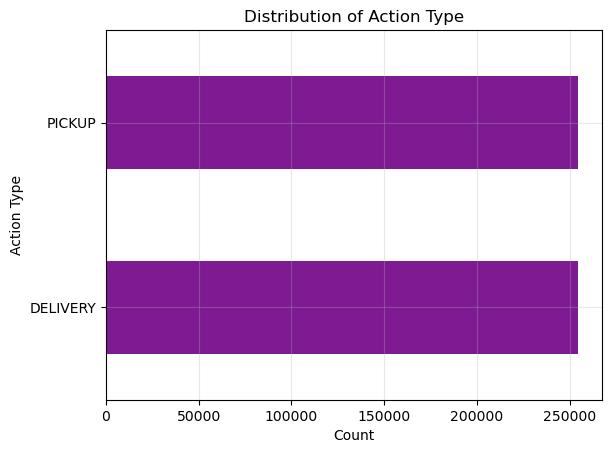

In [14]:
df.action_type.value_counts().plot(
    kind='barh', color=deep_colors[1], ylabel='Action Type',
    xlabel='Count', title='Distribution of Action Type'
)
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()

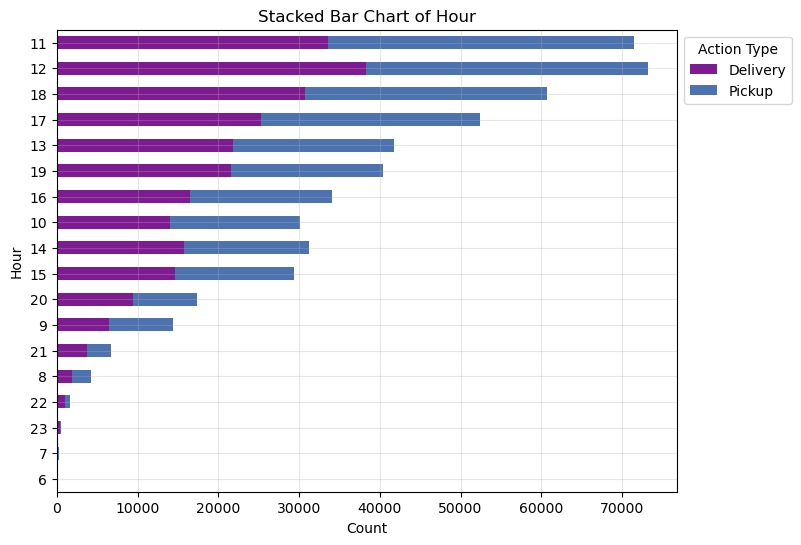

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.crosstab(df.hour, df.action_type).sort_values(by='PICKUP').plot(
    kind='barh', stacked=True, ax=ax, color=(deep_colors[1], deep_colors[2])
)
ax.set_title('Stacked Bar Chart of Hour')
ax.set_ylabel('Hour')
ax.set_xlabel('Count')
ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=.3)
plt.show()

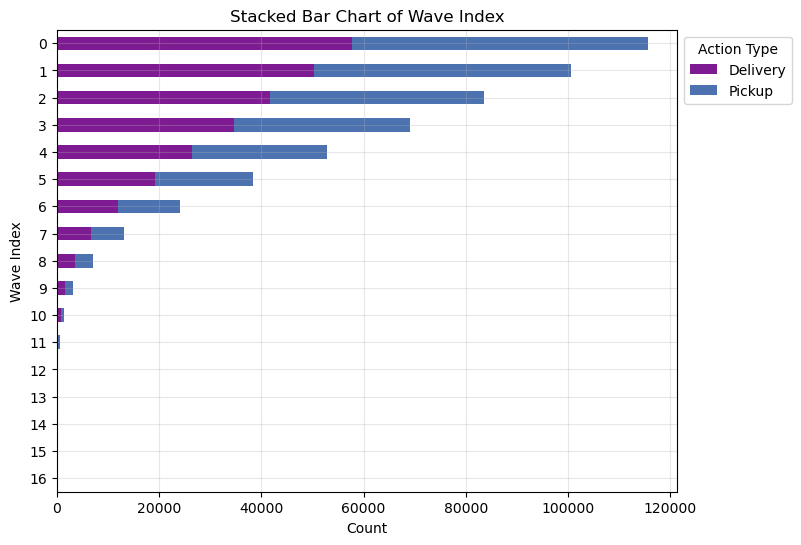

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.crosstab(df.wave_index, df.action_type).plot(
    kind='barh', stacked=True, ax=ax, color=(deep_colors[1], deep_colors[2])
)
ax.set_title('Stacked Bar Chart of Wave Index')
ax.set_ylabel('Wave Index')
ax.set_xlabel('Count')
ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
ax.invert_yaxis()
plt.grid(alpha=.3)
plt.show()

The level feature describes the level of the courier.

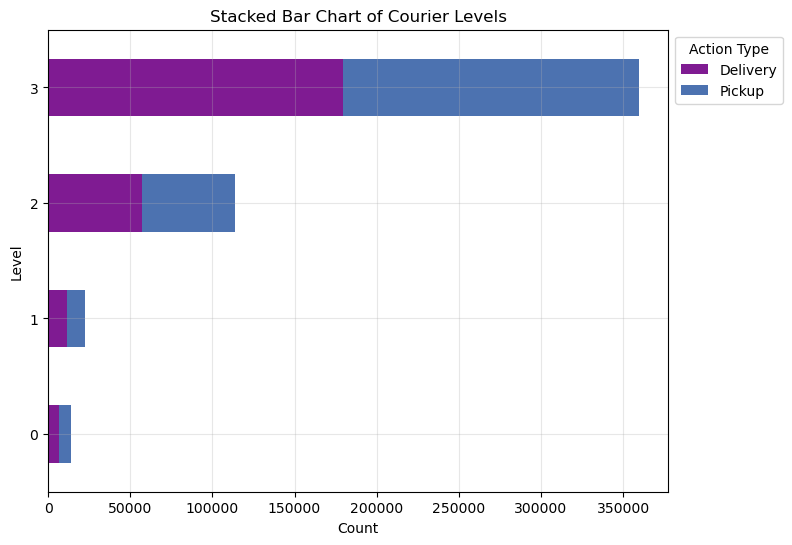

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.crosstab(df.level, df.action_type).plot(
    kind='barh', stacked=True, ax=ax, color=(deep_colors[1], deep_colors[2])
)
ax.set_title('Stacked Bar Chart of Courier Levels')
ax.set_ylabel('Level')
ax.set_xlabel('Count')
ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=.3)
plt.show()

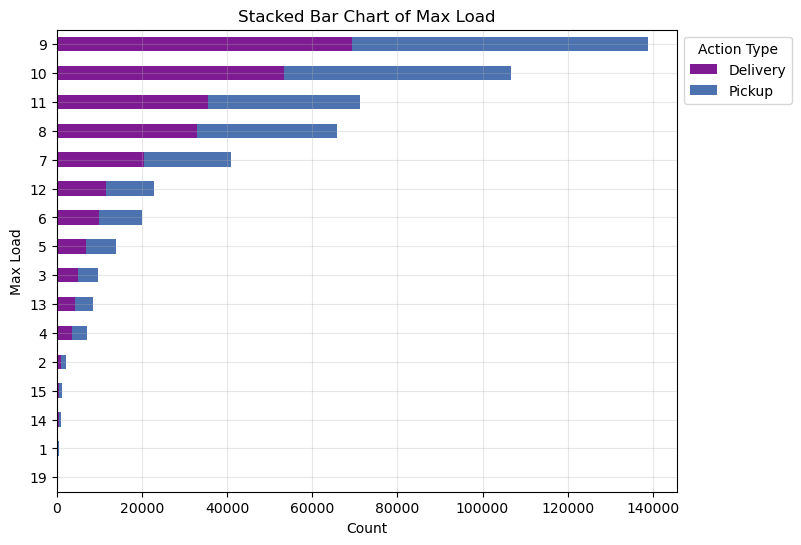

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.crosstab(df.max_load, df.action_type).sort_values(by='PICKUP').plot(
    kind='barh', stacked=True, ax=ax, color=(deep_colors[1], deep_colors[2])
)
ax.set_title('Stacked Bar Chart of Max Load')
ax.set_ylabel('Max Load')
ax.set_xlabel('Count')
ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=.3)
plt.show()

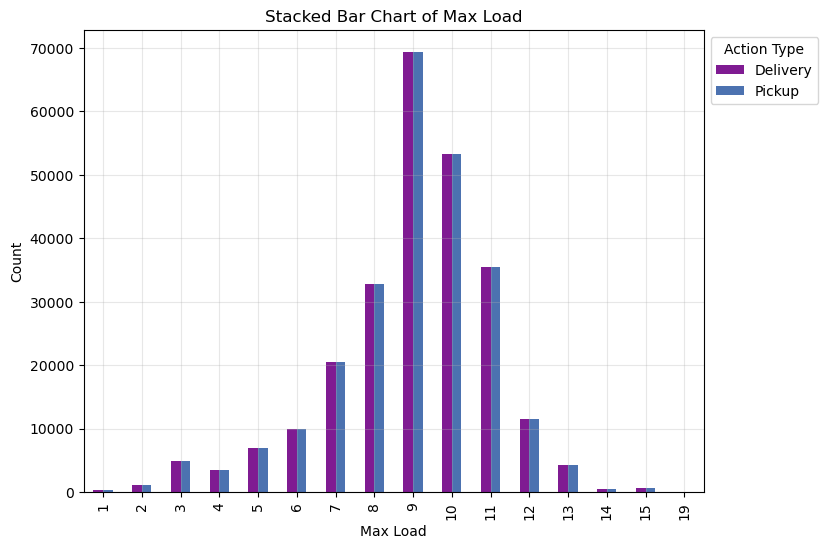

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.crosstab(df.max_load, df.action_type).plot(
    kind='bar', ax=ax, color=(deep_colors[1], deep_colors[2])
)
ax.set_title('Stacked Bar Chart of Max Load')
ax.set_xlabel('Max Load')
ax.set_ylabel('Count')
ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=.3)
plt.show()

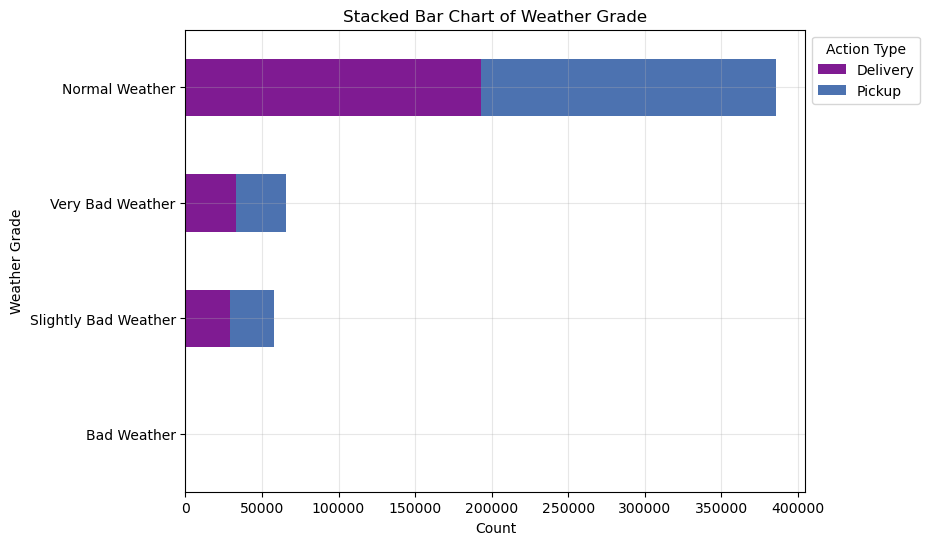

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.crosstab(df.weather_grade, df.action_type).sort_values(by='PICKUP').plot(
    kind='barh', stacked=True, ax=ax, color=(deep_colors[1], deep_colors[2])
)
ax.set_title('Stacked Bar Chart of Weather Grade')
ax.set_ylabel('Weather Grade')
ax.set_xlabel('Count')
ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=.3)
plt.show()

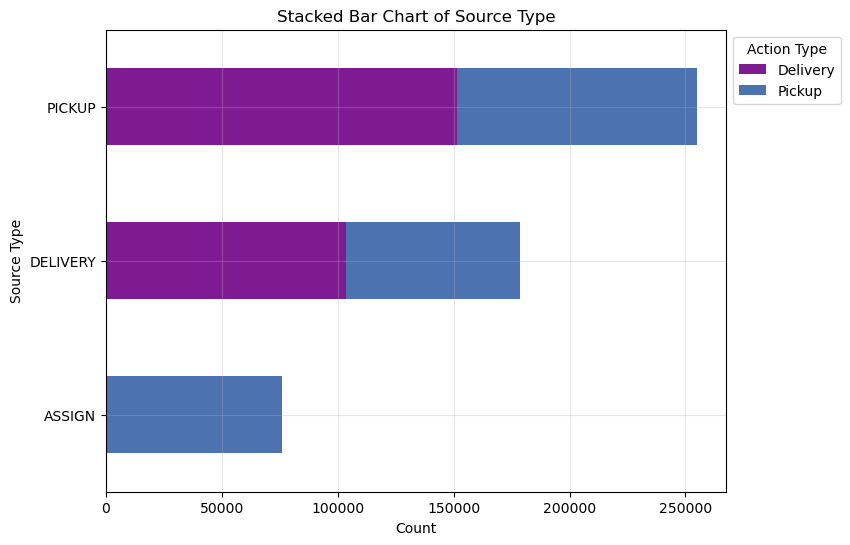

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

pd.crosstab(df.source_type, df.action_type).sort_values(by='DELIVERY').plot(
    kind='barh', stacked=True, ax=ax, color=(deep_colors[1], deep_colors[2])
)
ax.set_title('Stacked Bar Chart of Source Type')
ax.set_ylabel('Source Type')
ax.set_xlabel('Count')
ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=.3)
plt.show()

Location Variables:

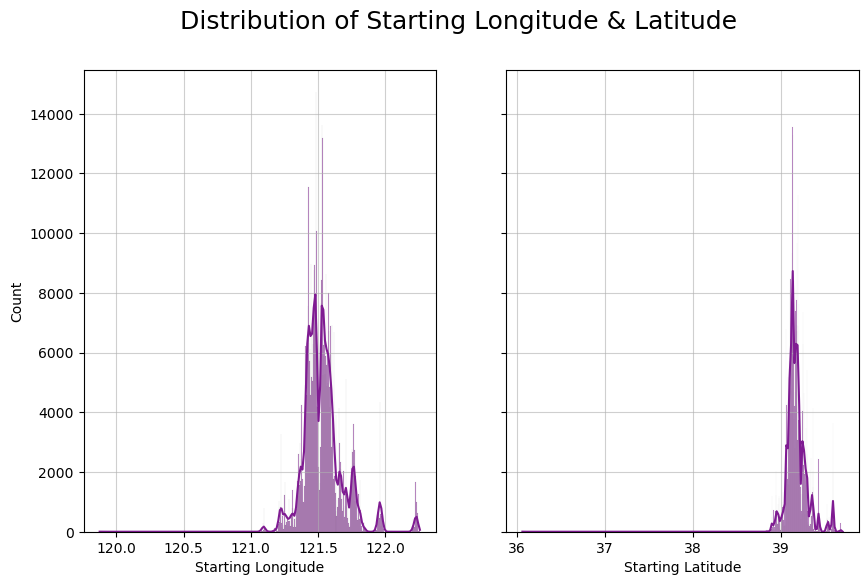

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
sns.histplot(
    data=df, x="courier_wave_start_lng", kde=True,
    color=deep_colors[1], ax=ax[0]
)
sns.histplot(
    data=df, x="courier_wave_start_lat", kde=True,
    color=deep_colors[1], ax=ax[1]
)
ax[0].set_xlabel('Starting Longitude')
ax[1].set_xlabel('Starting Latitude')
ax[0].set_ylabel('Count')
ax[1].set_ylabel('')
ax[0].grid(alpha=.6)
ax[1].grid(alpha=.6)
plt.suptitle('Distribution of Starting Longitude & Latitude', fontsize=18)
plt.show()

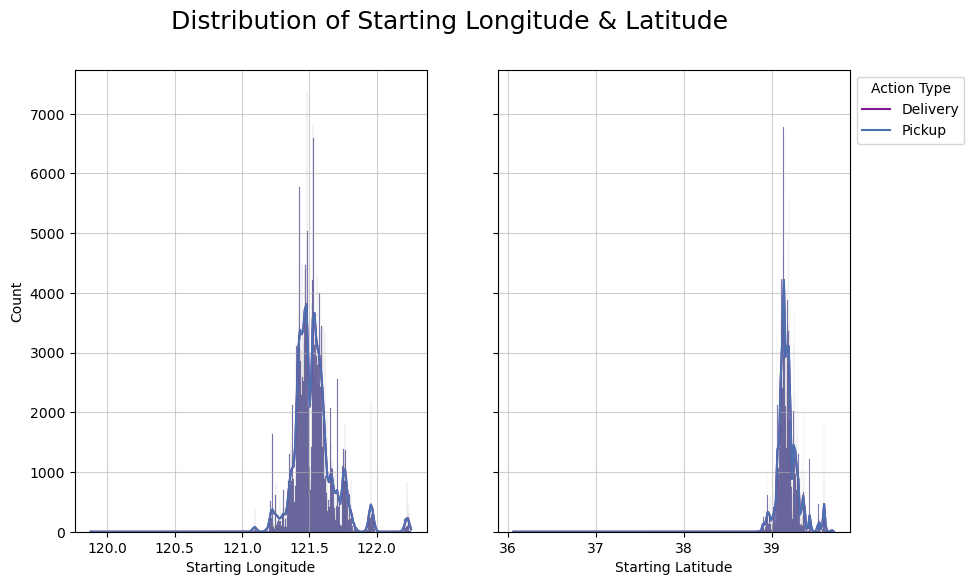

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
sns.histplot(
    data=df, x="courier_wave_start_lng", kde=True, ax=ax[0],
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]},
    legend=False
)
sns.histplot(
    data=df, x="courier_wave_start_lat", kde=True, ax=ax[1],
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]}
)
ax[0].set_xlabel('Starting Longitude')
ax[0].set_ylabel('Count')
ax[0].grid(alpha=.6)

ax[1].set_xlabel('Starting Latitude')
ax[1].set_ylabel('')
ax[1].grid(alpha=.6)
ax[1].legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))

plt.suptitle('Distribution of Starting Longitude & Latitude', fontsize=18)
plt.show()

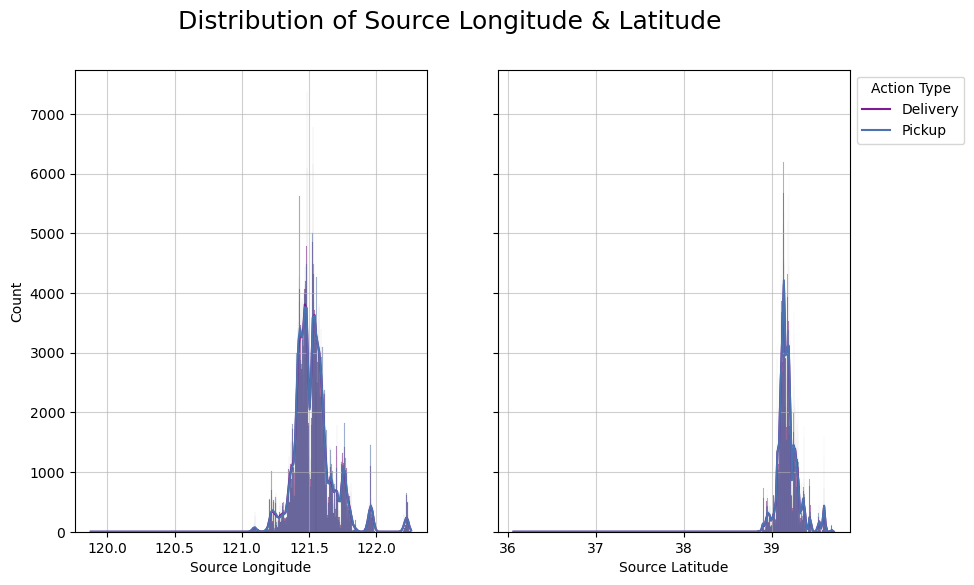

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
sns.histplot(
    data=df, x="source_lng", kde=True, ax=ax[0],
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]},
    legend=False
)
sns.histplot(
    data=df, x="source_lat", kde=True, ax=ax[1],
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]}
)
ax[0].set_xlabel('Source Longitude')
ax[0].set_ylabel('Count')
ax[0].grid(alpha=.6)

ax[1].set_xlabel('Source Latitude')
ax[1].set_ylabel('')
ax[1].grid(alpha=.6)
ax[1].legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))

plt.suptitle('Distribution of Source Longitude & Latitude', fontsize=18)
plt.show()

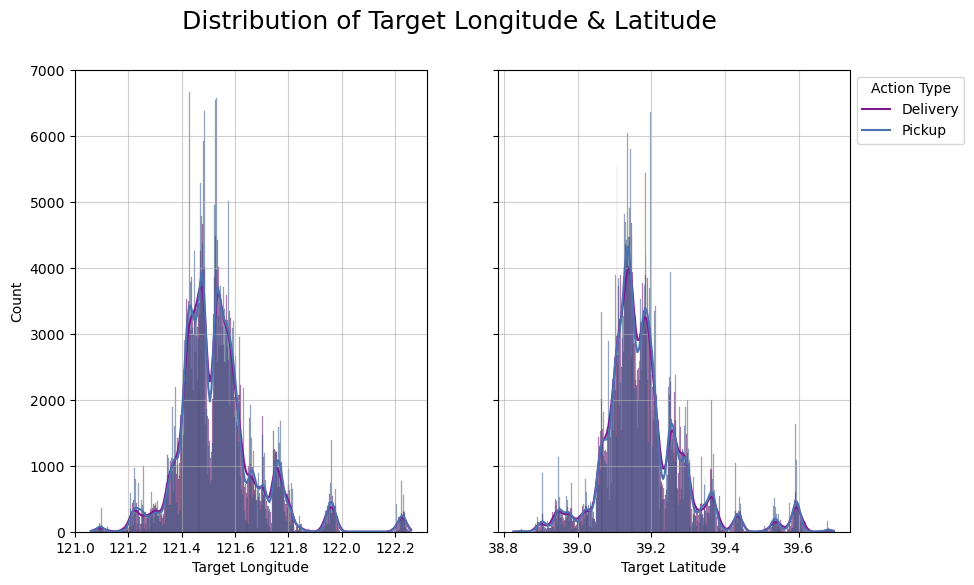

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
sns.histplot(
    data=df, x="target_lng", kde=True, ax=ax[0],
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]},
    legend=False
)
sns.histplot(
    data=df, x="target_lat", kde=True, ax=ax[1],
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]}
)
ax[0].set_xlabel('Target Longitude')
ax[0].set_ylabel('Count')
ax[0].grid(alpha=.6)

ax[1].set_xlabel('Target Latitude')
ax[1].set_ylabel('')
ax[1].grid(alpha=.6)
ax[1].legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))

plt.suptitle('Distribution of Target Longitude & Latitude', fontsize=18)
plt.show()

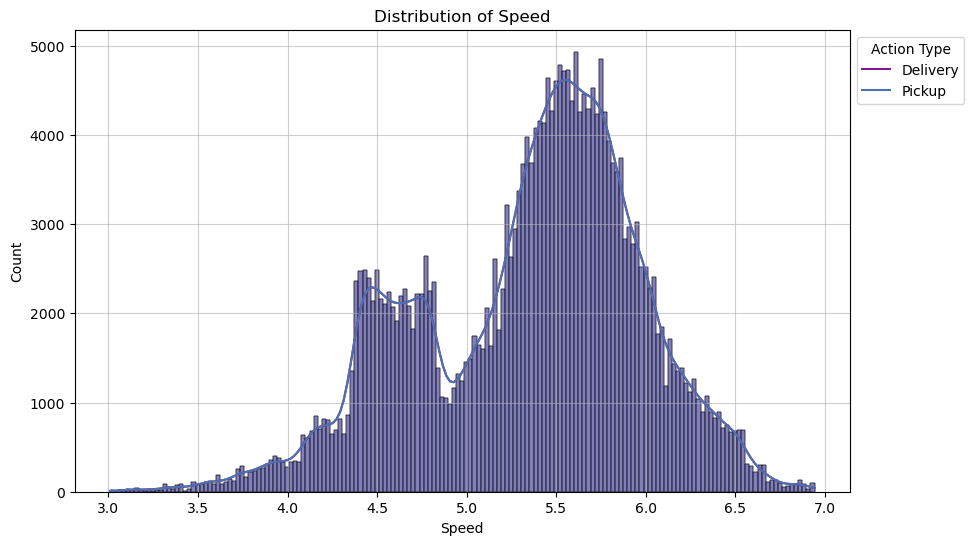

In [26]:
fig, ax = plt.subplots(figsize=(10, 6), sharey=True)
sns.histplot(
    data=df, x="speed", kde=True, ax=ax,
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]},
)

ax.set_xlabel('Speed')
ax.set_ylabel('Count')
ax.grid(alpha=.6)

ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Distribution of Speed')
plt.show()

Features with significant outliers: 
- grid_distance
- expected_use_time
- urgency

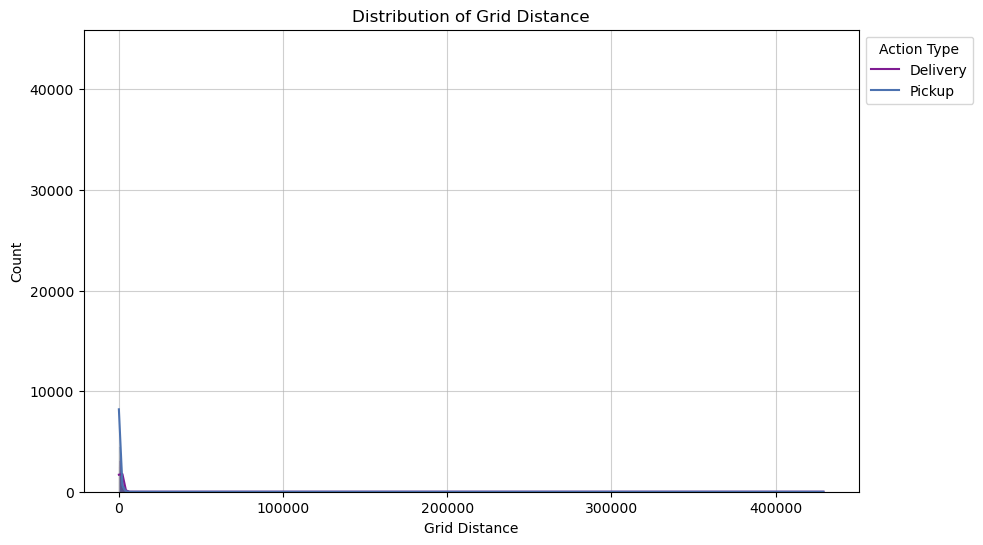

In [27]:
fig, ax = plt.subplots(figsize=(10, 6), sharey=True)
sns.histplot(
    data=df, x="grid_distance", kde=True, ax=ax,
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]},
)

ax.set_xlabel('Grid Distance')
ax.set_ylabel('Count')
ax.grid(alpha=.6)

ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Distribution of Grid Distance')
plt.show()

There are significant outliers in the second/ regression target variable.

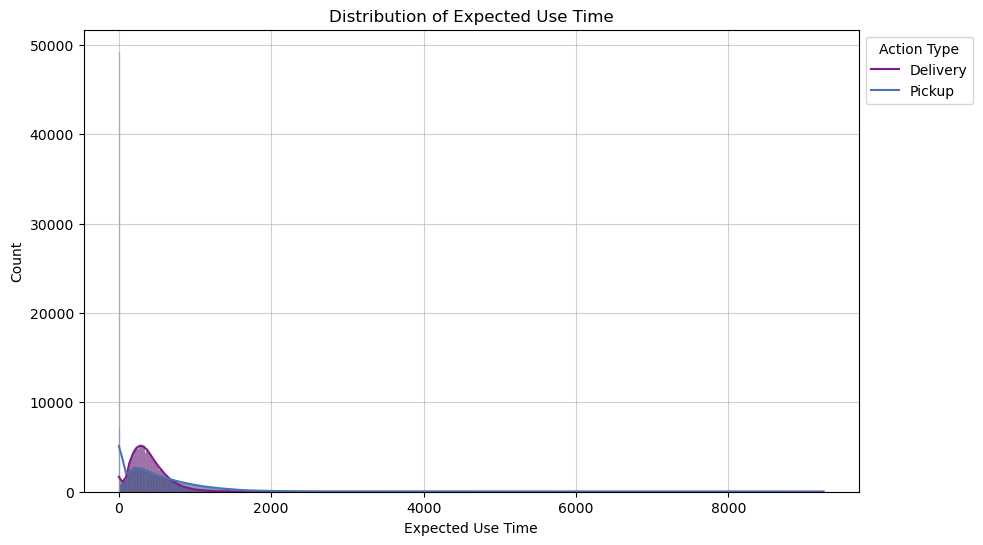

In [28]:
fig, ax = plt.subplots(figsize=(10, 6), sharey=True)
sns.histplot(
    data=df, x="expected_use_time", kde=True, ax=ax,
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]},
)

ax.set_xlabel('Expected Use Time')
ax.set_ylabel('Count')
ax.grid(alpha=.6)

ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Distribution of Expected Use Time')
plt.show()

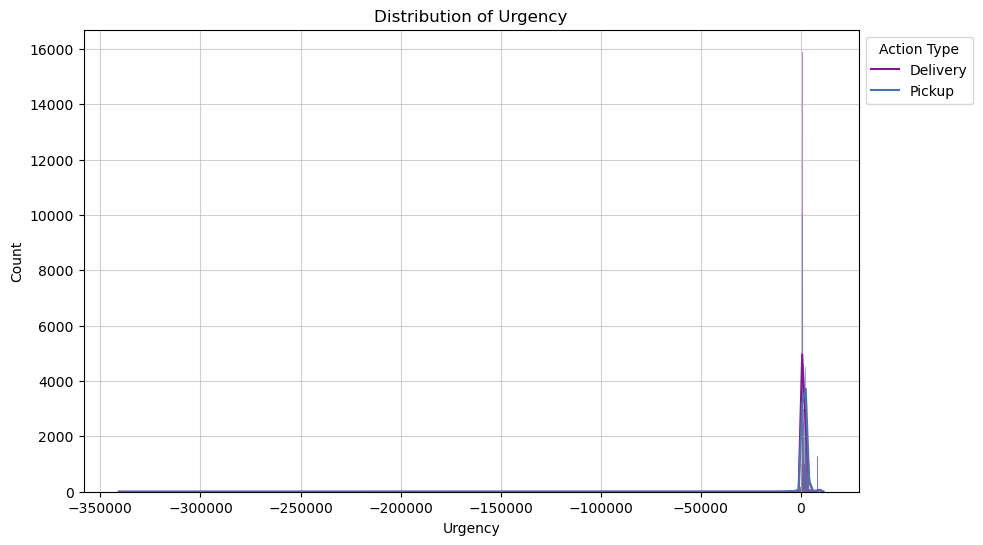

In [29]:
fig, ax = plt.subplots(figsize=(10, 6), sharey=True)
sns.histplot(
    data=df, x="urgency", kde=True, ax=ax,
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]},
)

ax.set_xlabel('Urgency')
ax.set_ylabel('Count')
ax.grid(alpha=.6)

ax.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
ax.set_title('Distribution of Urgency')
plt.show()

### Handling Outliers

In [30]:
outlier_cols = ['grid_distance', 'urgency']
df[outlier_cols].describe()

,grid_distance,urgency
count,509604.000000,509604.000000
mean,1078.274900,1572.033695
std,1124.569317,4344.556228
min,0.000000,-340771.000000
25%,330.000000,859.000000
50%,869.000000,1752.000000
75%,1572.000000,2590.000000
max,429173.000000,11345.000000


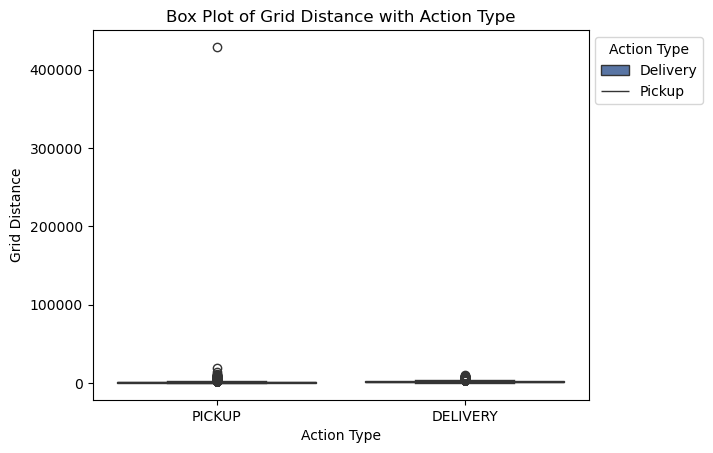

In [31]:
sns.boxplot(
    data=df, x='action_type', y=outlier_cols[0],
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]}
)

plt.xlabel('Action Type')
plt.ylabel('Grid Distance')
plt.title('Box Plot of Grid Distance with Action Type')
plt.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

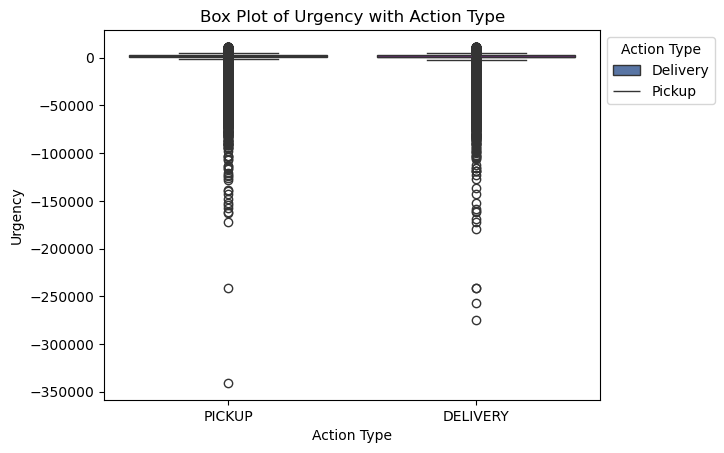

In [32]:
sns.boxplot(
    data=df, x='action_type', y=outlier_cols[1],
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]}
)

plt.xlabel('Action Type')
plt.ylabel('Urgency')
plt.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Box Plot of Urgency with Action Type')

plt.show()

Our first option in handling outliers is to remove them:

In [33]:
def remove_outliers(data, columns, k=1.5):
    for column in columns:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

no_outliers = remove_outliers(df[outlier_cols + ['action_type']], outlier_cols)
no_outliers.shape

(471938, 3)

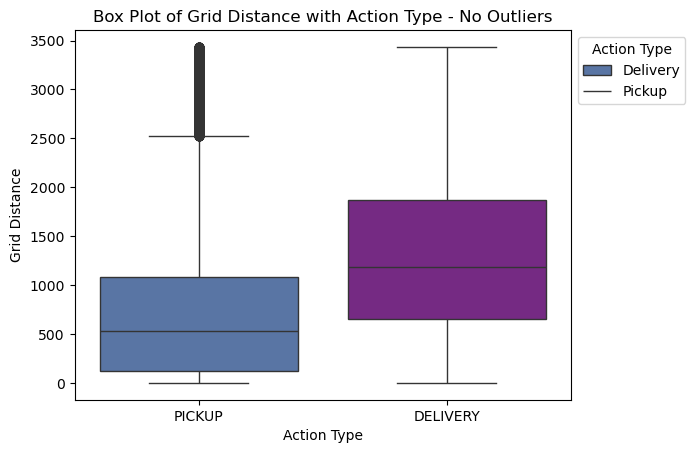

In [34]:
sns.boxplot(
    data=no_outliers, x='action_type', y=outlier_cols[0],
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]}
)

plt.xlabel('Action Type')
plt.ylabel('Grid Distance')
plt.title('Box Plot of Grid Distance with Action Type - No Outliers')
plt.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

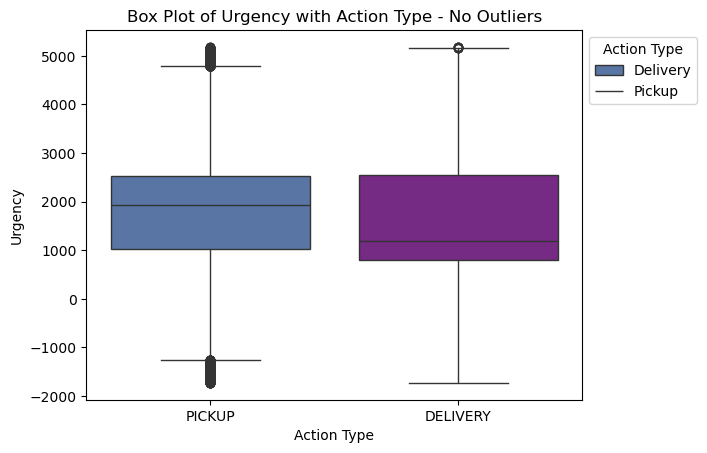

In [35]:
sns.boxplot(
    data=no_outliers, x='action_type', y=outlier_cols[1],
    hue='action_type', palette={'DELIVERY': deep_colors[1], 'PICKUP': deep_colors[2]}
)

plt.xlabel('Action Type')
plt.ylabel('Urgency')
plt.title('Box Plot of Urgency with Action Type - No Outliers')
plt.legend(title='Action Type', labels=['Delivery', 'Pickup'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Our second option is to transform the data:

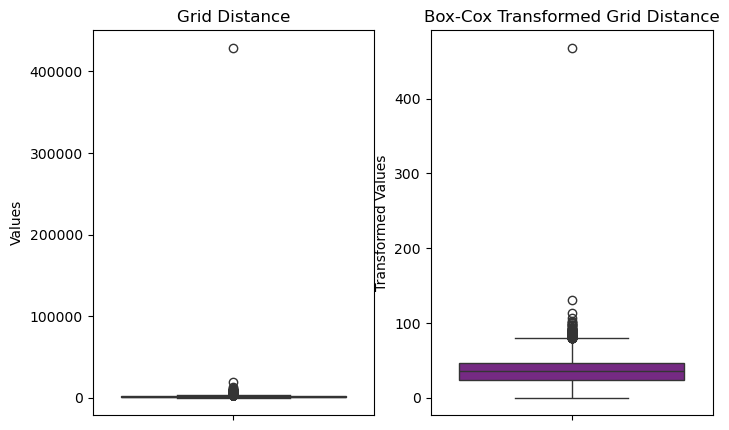

In [36]:
# Adding a constant to shift data
constant = 1  # Or any suitable constant to shift values
transformed_data, lambda_val = stats.boxcox(df[outlier_cols[0]] + constant)
df['transformed_grid_distance'] = transformed_data

plt.figure(figsize=(8, 5)) 
plt.subplot(1, 2, 1)
sns.boxplot(y=df.grid_distance, color=deep_colors[1])
plt.title('Grid Distance')
plt.ylabel('Values')

plt.subplot(1, 2, 2)
sns.boxplot(y=transformed_data, color=deep_colors[1])
plt.title('Box-Cox Transformed Grid Distance')
plt.ylabel('Transformed Values')

plt.show()

In [37]:
outlier_cols[1]

'urgency'

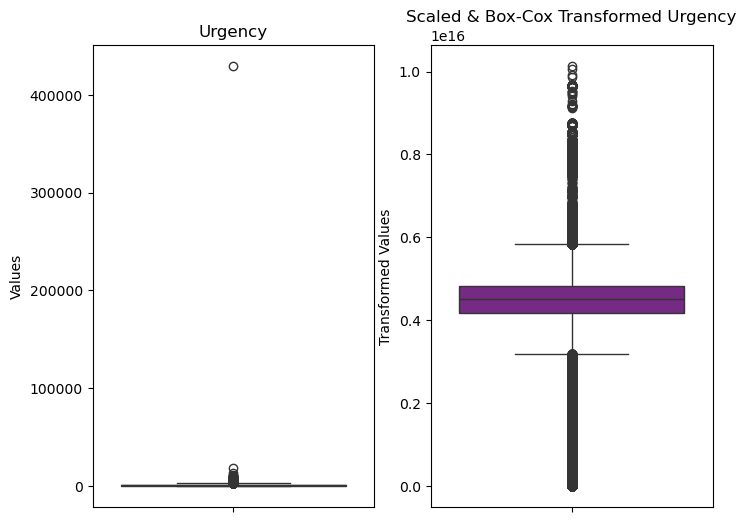

In [38]:
scaler = MinMaxScaler()
urgency_scaled = scaler.fit_transform(df[outlier_cols[1]].values.reshape(-1, 1))

constant = 1
transformed_data, lambda_val = stats.boxcox(urgency_scaled.reshape(-1) + constant)
df['transformed_urgency'] = transformed_data

plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df.grid_distance, color=deep_colors[1])
plt.title('Urgency')
plt.ylabel('Values')

plt.subplot(1, 2, 2)
sns.boxplot(y=transformed_data, color=deep_colors[1])
plt.title('Scaled & Box-Cox Transformed Urgency')
plt.ylabel('Transformed Values')

plt.show()

We'll use the original and transformed features in different models to determine which is better.

In [39]:
df.columns

Index(['wave_index', 'courier_wave_start_lng', 'courier_wave_start_lat',
       'action_type', 'date', 'level', 'speed', 'max_load', 'weather_grade',
       'source_type', 'source_lng', 'source_lat', 'target_lng', 'target_lat',
       'grid_distance', 'expected_use_time', 'urgency', 'hour',
       'transformed_grid_distance', 'transformed_urgency'],
      dtype='object')

### Statistical Testing

We'll test the following questions:
1. Does hour have an impact on action type and/ or expected use time?
2. Does wave index have an impact on action type and/ or expected use time?
3. Does level have an impact on action type and/ or expected use time?
4. Does max load have an impact on action type and/ or expected use time?
5. Does weather grade have an impact on action type and/ or expected use time?
6. Does source type have an impact on action type and/ or expected use time?
7. Does date have impact on action type and/ or expected use time?
8. Does source longitude have an impact on action type and/ or expected use time?
9. Does target longitude have an impact on action type and/ or expected use time?
10. Does courier wave start longitude have an impact on action type and/ or expected use time?
11. Does grid distance have an impact on action type and/ or expected use time?
12. Does urgency have an impact on action type and/ or expected use time?

We'll use the chi-squared test of independence to test the hypothesis where our predictor variable is a categorical variable and the logistic regression analysis where our predictor variable is a numerical variable. We'll use type 2 ANOVA to test our hypothesis when our target is a numerical variable.

With a p-value alpha of 0.05, if the resulting p-value is less than or equal to alpha, we reject the null hypothesis. The null hypothesis is the negative response to our questions. 

1. Does hour have an impact on action type and/ or expected use time?

In [40]:
contingency_table = pd.crosstab(df.hour, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
hour,,
6,8,25
7,121,154
8,1798,2403
9,6463,7904
10,13999,16087
11,33537,37948
12,38330,34828
13,21837,19861
14,15733,15527


P-value:  3.79676319442508e-303
For action type, we reject the null hypothesis.


In [41]:
model = smf.ols('expected_use_time ~ C(hour)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                sum_sq        df          F         PR(>F)
C(hour)   2.146979e+08      17.0  77.160952  3.174560e-268
Residual  8.340628e+10  509586.0        NaN            NaN

P-value:  3.174560071425637e-268
For expected use time, we reject the null hypothesis.


2. Does wave index have an impact on action type and/ or expected use time?

In [42]:
contingency_table = pd.crosstab(df.wave_index, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
wave_index,,
0,57770,57770
1,50291,50291
2,41728,41728
3,34577,34577
4,26451,26451
5,19158,19158
6,12019,12019
7,6564,6564
8,3538,3538


P-value:  1.0
For action type, we fail to reject the null hypothesis.


In [43]:
model = smf.ols('expected_use_time ~ C(wave_index)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                     sum_sq        df          F        PR(>F)
C(wave_index)  5.219547e+07      16.0  19.892395  4.323941e-58
Residual       8.356879e+10  509587.0        NaN           NaN

P-value:  4.323940860787174e-58
For expected use time, we reject the null hypothesis.


3. Does level have an impact on action type and/ or expected use time?

In [44]:
contingency_table = pd.crosstab(df.level, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
level,,
0,6866,6866
1,11242,11242
2,56969,56969
3,179725,179725


P-value:  1.0
For action type, we fail to reject the null hypothesis.


In [45]:
model = smf.ols('expected_use_time ~ C(level)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                sum_sq        df          F        PR(>F)
C(level)  1.414785e+07       3.0  28.744646  1.415197e-18
Residual  8.360683e+10  509600.0        NaN           NaN

P-value:  1.4151966665506608e-18
For expected use time, we reject the null hypothesis.


4. Does max load have an impact on action type and/ or expected use time?

In [46]:
contingency_table = pd.crosstab(df.max_load, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
max_load,,
1,272,272
2,1034,1034
3,4855,4855
4,3487,3487
5,6919,6919
6,9931,9931
7,20418,20418
8,32845,32845
9,69384,69384


P-value:  1.0
For action type, we fail to reject the null hypothesis.


In [47]:
model = smf.ols('expected_use_time ~ C(max_load)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                   sum_sq        df          F        PR(>F)
C(max_load)  7.378498e+07      15.0  30.002952  2.212101e-86
Residual     8.354720e+10  509588.0        NaN           NaN

P-value:  2.212101453315473e-86
For expected use time, we reject the null hypothesis.


5. Does weather grade have an impact on action type and/ or expected use time?

In [48]:
contingency_table = pd.crosstab(df.weather_grade, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
weather_grade,,
Bad Weather,125,125
Normal Weather,192842,192842
Slightly Bad Weather,28855,28855
Very Bad Weather,32980,32980


P-value:  1.0
For action type, we fail to reject the null hypothesis.


In [49]:
model = smf.ols('expected_use_time ~ C(weather_grade)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                        sum_sq        df           F         PR(>F)
C(weather_grade)  1.051702e+08       3.0  213.910542  1.105185e-138
Residual          8.351581e+10  509600.0         NaN            NaN

P-value:  1.1051846469233466e-138
For expected use time, we reject the null hypothesis.


6. Does source type have an impact on action type and/ or expected use time?

In [50]:
contingency_table = pd.crosstab(df.source_type, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
source_type,,
ASSIGN,0,76069
DELIVERY,103342,75391
PICKUP,151460,103342


P-value:  0.0
For action type, we reject the null hypothesis.


In [51]:
model = smf.ols('expected_use_time ~ C(source_type)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                      sum_sq        df             F  PR(>F)
C(source_type)  1.407859e+10       2.0  51583.377875     0.0
Residual        6.954239e+10  509601.0           NaN     NaN

P-value:  0.0
For expected use time, we reject the null hypothesis.


7. Does date have impact on action type and/ or expected use time?

In [52]:
contingency_table = pd.crosstab(df.date, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
date,,
2020-02-01,7111,7111
2020-02-02,8179,8179
2020-02-03,7284,7284
2020-02-04,7780,7780
2020-02-05,7885,7885
2020-02-06,7526,7526
2020-02-07,8199,8199
2020-02-08,8615,8615
2020-02-09,8409,8409


P-value:  1.0
For action type, we fail to reject the null hypothesis.


In [53]:
model = smf.ols('expected_use_time ~ C(date)', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                sum_sq        df          F  PR(>F)
C(date)   4.037887e+08      26.0  95.099348     0.0
Residual  8.321719e+10  509577.0        NaN     NaN

P-value:  0.0
For expected use time, we reject the null hypothesis.


8. Does source longitude have an impact on action type and/ or expected use time?

In [54]:
contingency_table = pd.crosstab(df.source_lng, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
source_lng,,
119.876654,0,1
121.059744,1,0
121.062624,0,1
121.063724,1,0
121.064354,1,0
...,...,...
122.255987,0,1
122.256027,0,1
122.256083,0,1


P-value:  0.0
For action type, we reject the null hypothesis.


In [55]:
model = smf.ols('expected_use_time ~ source_lng', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                  sum_sq        df        F   PR(>F)
source_lng  1.155066e+05       1.0  0.70392  0.40147
Residual    8.362087e+10  509602.0      NaN      NaN

P-value:  0.4014700082652255
For expected use time, we fail to reject the null hypothesis.


9. Does target longitude have an impact on action type and/ or expected use time?

In [56]:
contingency_table = pd.crosstab(df.target_lng, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
target_lng,,
121.059274,1,0
121.059634,1,0
121.059744,1,0
121.060144,1,0
121.062624,1,0
...,...,...
122.255784,1,0
122.256424,1,0
122.258364,1,0


P-value:  0.0
For action type, we reject the null hypothesis.


In [57]:
model = smf.ols('expected_use_time ~ target_lng', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                  sum_sq        df         F    PR(>F)
target_lng  1.271937e+05       1.0  0.775144  0.378631
Residual    8.362085e+10  509602.0       NaN       NaN

P-value:  0.3786308954911276
For expected use time, we fail to reject the null hypothesis.


10. Does courier wave start longitude have an impact on action type and/ or expected use time?

In [58]:
contingency_table = pd.crosstab(df.courier_wave_start_lng, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
courier_wave_start_lng,,
119.876654,7,7
121.064581,2,2
121.073916,2,2
121.073926,3,3
121.073934,2,2
...,...,...
122.255870,6,6
122.255987,2,2
122.256027,2,2


P-value:  1.0
For action type, we fail to reject the null hypothesis.


In [59]:
model = smf.ols('expected_use_time ~ courier_wave_start_lng', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                              sum_sq        df         F    PR(>F)
courier_wave_start_lng  1.424582e+05       1.0  0.868169  0.351463
Residual                8.362084e+10  509602.0       NaN       NaN

P-value:  0.35146320395097885
For expected use time, we fail to reject the null hypothesis.


11. Does grid distance have an impact on action type and/ or expected use time?

In [60]:
contingency_table = pd.crosstab(df.grid_distance, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
grid_distance,,
0.00000,39,0
1.00000,6459,36042
2.00000,658,3190
3.00000,16,58
4.00000,10,103
...,...,...
10462.00000,0,1
11664.00000,0,1
13342.00000,0,1


P-value:  0.0
For action type, we reject the null hypothesis.


In [61]:
model = smf.ols('expected_use_time ~ grid_distance', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                     sum_sq        df             F  PR(>F)
grid_distance  6.387024e+09       1.0  42142.606704     0.0
Residual       7.723396e+10  509602.0           NaN     NaN

P-value:  0.0
For expected use time, we reject the null hypothesis.


12. Does urgency have an impact on action type and/ or expected use time?

In [62]:
contingency_table = pd.crosstab(df.urgency, df.action_type)
display(contingency_table)

chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print('P-value: ', p_val)
if p_val <= 0.05:
    print('For action type, we reject the null hypothesis.')
else:
    print('For action type, we fail to reject the null hypothesis.')

action_type,DELIVERY,PICKUP
urgency,,
-340771,0,1
-274408,1,0
-257289,1,0
-241126,1,1
-240972,1,0
...,...,...
10808,1,1
11043,0,1
11089,1,0


P-value:  0.0
For action type, we reject the null hypothesis.


In [63]:
model = smf.ols('expected_use_time ~ urgency', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

p_val = anova_table.iloc[0, 3]
print('\nP-value: ', p_val)
if p_val <= 0.05:
    print('For expected use time, we reject the null hypothesis.')
else:
    print('For expected use time, we fail to reject the null hypothesis.')

                sum_sq        df            F  PR(>F)
urgency   8.422296e+08       1.0  5184.928205     0.0
Residual  8.277875e+10  509602.0          NaN     NaN

P-value:  0.0
For expected use time, we reject the null hypothesis.


From our statistical tests, the following features do not have any significant impact on both action type and expected use time and will be removed from the modeled data:
* Courier Wave Location

### Feature Engineering

In [64]:
train = read_csv_from_zip(zip_file_path, ba2023_files[1])

In [65]:
def initial_cleaning(data, date_col, action_type_col=None):
    drop_cols = ['courier_id', 'tracking_id', 'id', 'group', 'source_tracking_id', 'aoi_id', 'shop_id', 'courier_wave_start_lng', 'courier_wave_start_lat']
    data = data.drop(drop_cols, axis=1)
    
    if action_type_col:
        data[date_col] = pd.to_datetime(data[date_col], format='%Y%m%d')
        data[action_type_col] = data[action_type_col].apply(lambda y: 1 if y.lower() == 'delivery' else 0)
    else:
        data[date_col] = pd.to_datetime(data[date_col], format='%Y%m%d')
    data['year'] = data[date_col].dt.year
    data['month'] = data[date_col].dt.month
    data['day'] = data[date_col].dt.day
    
    data = data.drop(columns=date_col)
    
    return data


def boxcox_transform(x):
    x = x.values
    transformed, _ = stats.boxcox(x)
    return transformed.reshape(-1, 1)

def boxcox_transform_with_constant(x, constant):
    if isinstance(x, pd.DataFrame):
        x = x.values.reshape(-1)
    else:
        x = x.reshape(-1)
    transformed, _ = stats.boxcox(x + constant)
    return transformed.reshape(-1, 1)

In [66]:
train = initial_cleaning(train, 'date', action_type_col='action_type')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509604 entries, 0 to 509603
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   wave_index         509604 non-null  int64  
 1   action_type        509604 non-null  int64  
 2   level              509604 non-null  int64  
 3   speed              509604 non-null  float64
 4   max_load           509604 non-null  int64  
 5   weather_grade      509604 non-null  object 
 6   source_type        509604 non-null  object 
 7   source_lng         509604 non-null  float64
 8   source_lat         509604 non-null  float64
 9   target_lng         509604 non-null  float64
 10  target_lat         509604 non-null  float64
 11  grid_distance      509604 non-null  float64
 12  expected_use_time  509604 non-null  int64  
 13  urgency            509604 non-null  int64  
 14  hour               509604 non-null  int64  
 15  year               509604 non-null  int32  
 16  mo

In [67]:
# Pipeline no Transformations

ordinal_encoder = OrdinalEncoder(categories=[['Normal Weather', 'Slightly Bad Weather', 'Bad Weather', 'Very Bad Weather']])
one_hot_encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', ordinal_encoder, ['weather_grade']),
        ('one_hot', one_hot_encoder, ['source_type']),
    ],
    remainder='passthrough' 
)

pipeline = Pipeline([('preprocessor', preprocessor),])
pipeline.fit(train)
transformed_data = pipeline.transform(train)

cols = ['wave_index', 'action_type', 'level', 'speed', 'max_load', 'source_lng', 'source_lat', 'target_lng', 'target_lat', 'grid_distance', 'expected_use_time', 'urgency', 'hour', 'year', 'month', 'day']
column_names = list()
for name, transformer, columns in pipeline.named_steps['preprocessor'].transformers:
    if name == 'one_hot':
        column_names.extend(pipeline.named_steps['preprocessor'].named_transformers_[name].get_feature_names_out(columns))
    else:
        column_names.extend(columns)
column_names.extend(cols)

train2 = pd.DataFrame(transformed_data, columns=column_names)
train2 = train2.apply(pd.to_numeric, errors='ignore')
train2.columns = train2.columns.str.lower()
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509604 entries, 0 to 509603
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   weather_grade         509604 non-null  float64
 1   source_type_assign    509604 non-null  float64
 2   source_type_delivery  509604 non-null  float64
 3   source_type_pickup    509604 non-null  float64
 4   wave_index            509604 non-null  float64
 5   action_type           509604 non-null  float64
 6   level                 509604 non-null  float64
 7   speed                 509604 non-null  float64
 8   max_load              509604 non-null  float64
 9   source_lng            509604 non-null  float64
 10  source_lat            509604 non-null  float64
 11  target_lng            509604 non-null  float64
 12  target_lat            509604 non-null  float64
 13  grid_distance         509604 non-null  float64
 14  expected_use_time     509604 non-null  float64
 15  

In [68]:
# Creating a pipeline for feature transformations
constant_urgency = 1
constant_distance = 1

column_transformer = ColumnTransformer([
    ('ordinal_encoder', OrdinalEncoder(
        categories=[['Normal Weather', 'Slightly Bad Weather', 'Bad Weather', 'Very Bad Weather']]
    ), ['weather_grade']),
    ('one_hot', OneHotEncoder(), ['source_type']),
    ('min_max_scaling_and_boxcox', Pipeline([
        ('min_max_scaler', MinMaxScaler()),
        ('boxcox_transform', FunctionTransformer(func=boxcox_transform_with_constant, kw_args={'constant': constant_urgency}))
    ]), ['urgency']),
    ('boxcox_transform_feature4', FunctionTransformer(func=boxcox_transform_with_constant, kw_args={'constant': constant_distance}), ['grid_distance'])
], remainder='passthrough')

transformed_data = column_transformer.fit_transform(train)

transformed_feature_names = ['weather_grade_encoded'] + ['source_type_'  + cat.lower() for cat in train['source_type'].unique()]
transformed_feature_names.extend(['urgency_transformed', 'grid_distance_transformed', 'wave_index', 'action_type', 'level', 'speed', 'max_load', 'source_lng', 'source_lat', 'target_lng', 'target_lat', 'expected_use_time', 'hour', 'year', 'month', 'day'])

transformed_df = pd.DataFrame(transformed_data, columns=transformed_feature_names)
transformed_df = pd.concat([transformed_df, train[['urgency', 'grid_distance']]], axis=1)
transformed_df = transformed_df.apply(pd.to_numeric, errors='ignore')
transformed_df.head()

,weather_grade_encoded,source_type_assign,source_type_pickup,source_type_delivery,urgency_transformed,grid_distance_transformed,wave_index,action_type,level,speed,...,source_lat,target_lng,target_lat,expected_use_time,hour,year,month,day,urgency,grid_distance
0,0.0,1.0,0.0,0.0,4.316965e+15,24.826068,0.0,0.0,3.0,4.751832,...,39.142343,121.632547,39.141946,804.0,11.0,2020.0,2.0,1.0,1246,377.0
1,0.0,0.0,0.0,1.0,4.316965e+15,34.146255,0.0,1.0,3.0,4.751832,...,39.141946,121.626144,39.140281,298.0,11.0,2020.0,2.0,1.0,1246,780.0
2,0.0,0.0,1.0,0.0,4.787046e+15,29.324228,0.0,0.0,3.0,4.751832,...,39.140281,121.631219,39.141811,545.0,11.0,2020.0,2.0,1.0,2462,550.0
3,0.0,0.0,0.0,1.0,4.301933e+15,32.720273,0.0,1.0,3.0,4.751832,...,39.141811,121.632084,39.146201,341.0,11.0,2020.0,2.0,1.0,1205,707.0
4,0.0,0.0,1.0,0.0,4.556868e+15,33.955746,0.0,0.0,3.0,4.751832,...,39.146201,121.631574,39.142231,166.0,11.0,2020.0,2.0,1.0,1882,770.0


### Train-Test Split

Non-Transformed X, y

In [69]:
X = train2.drop(columns=['action_type', 'expected_use_time'])
y1 = train2['action_type']
y2 = train2['expected_use_time']

X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=2)
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(X_train, y1_train, y2_train, test_size=0.2, random_state=3)

print(X_train.shape, X_test.shape, X_val.shape)

(326146, 18) (101921, 18) (81537, 18)


Non-Transformed X, y (Outliers Removed)

In [70]:
def remove_outliers(data, columns, k=1.5):
    for column in columns:
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - k * iqr
        upper_bound = q3 + k * iqr
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return data

outlier_cols = ['grid_distance', 'urgency']
no_outliers = remove_outliers(train2, outlier_cols)
no_outliers.shape

(471938, 20)

In [71]:
Xno = no_outliers.drop(columns=['action_type', 'expected_use_time'])
y1no = no_outliers['action_type']
y2no = no_outliers['expected_use_time']

Xno_train, Xno_test, y1no_train, y1no_test, y2no_train, y2no_test = train_test_split(Xno, y1no, y2no, test_size=0.2, random_state=2)
Xno_train, Xno_val, y1no_train, y1no_val, y2no_train, y2no_val = train_test_split(Xno_train, y1no_train, y2no_train, test_size=0.2, random_state=3)

print(Xno_train.shape, Xno_test.shape, Xno_val.shape)

(302040, 18) (94388, 18) (75510, 18)


Transformed X, y

In [72]:
Xtr = transformed_df.drop(columns=['action_type', 'expected_use_time', 'grid_distance', 'urgency'])
y1tr = transformed_df['action_type']
y2tr = transformed_df['expected_use_time']

Xtr_train, Xtr_test, y1tr_train, y1tr_test, y2tr_train, y2tr_test = train_test_split(Xtr, y1, y2, test_size=0.2, random_state=2)
Xtr_train, Xtr_val, y1tr_train, y1tr_val, y2tr_train, y2tr_val = train_test_split(Xtr_train, y1tr_train, y2tr_train, test_size=0.2, random_state=3)

print(Xtr_train.shape, Xtr_test.shape, Xtr_val.shape)

(326146, 18) (101921, 18) (81537, 18)


This is the best linear model:

In [73]:
# create binary outcome variable
data = Xtr_train.copy()

# fit logistic regression model
X = data[['urgency_transformed', 'grid_distance_transformed']]
y = y1tr_train
X = sm.add_constant(X) # add intercept term
model = sm.Logit(y, X).fit()

# print model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.610286
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            action_type   No. Observations:               326146
Model:                          Logit   Df Residuals:                   326143
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:                  0.1195
Time:                        09:55:36   Log-Likelihood:            -1.9904e+05
converged:                       True   LL-Null:                   -2.2607e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.1563      0.023    -50.430      0.000      -1.

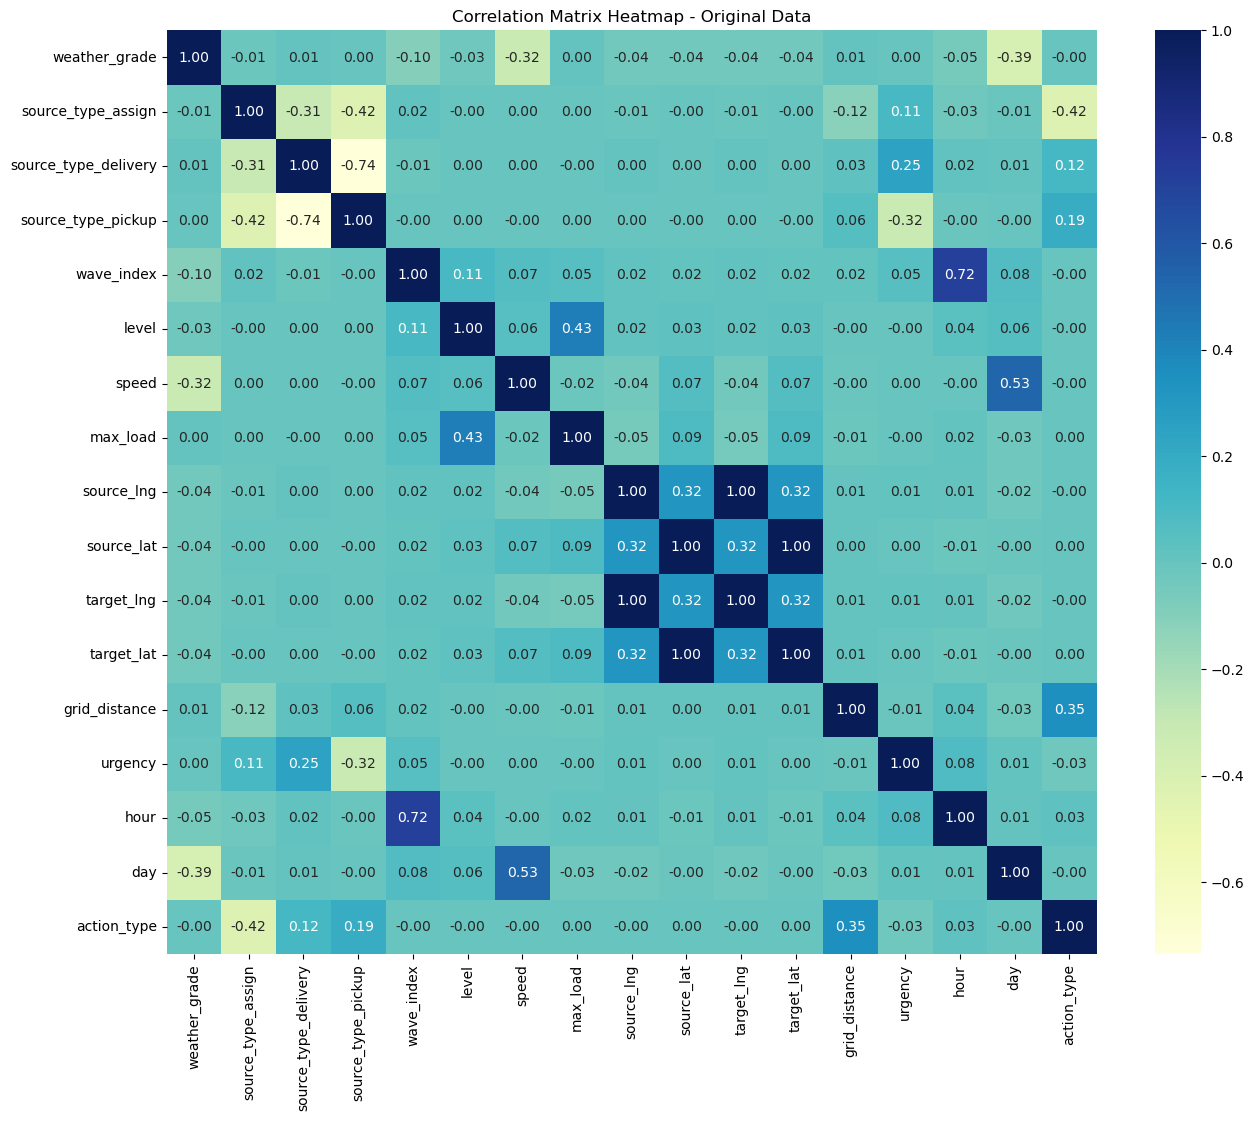

In [74]:
correlation_matrix = pd.concat([X_train.drop(columns=['year', 'month']), y1_train], axis=1).corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Matrix Heatmap - Original Data')
plt.show()

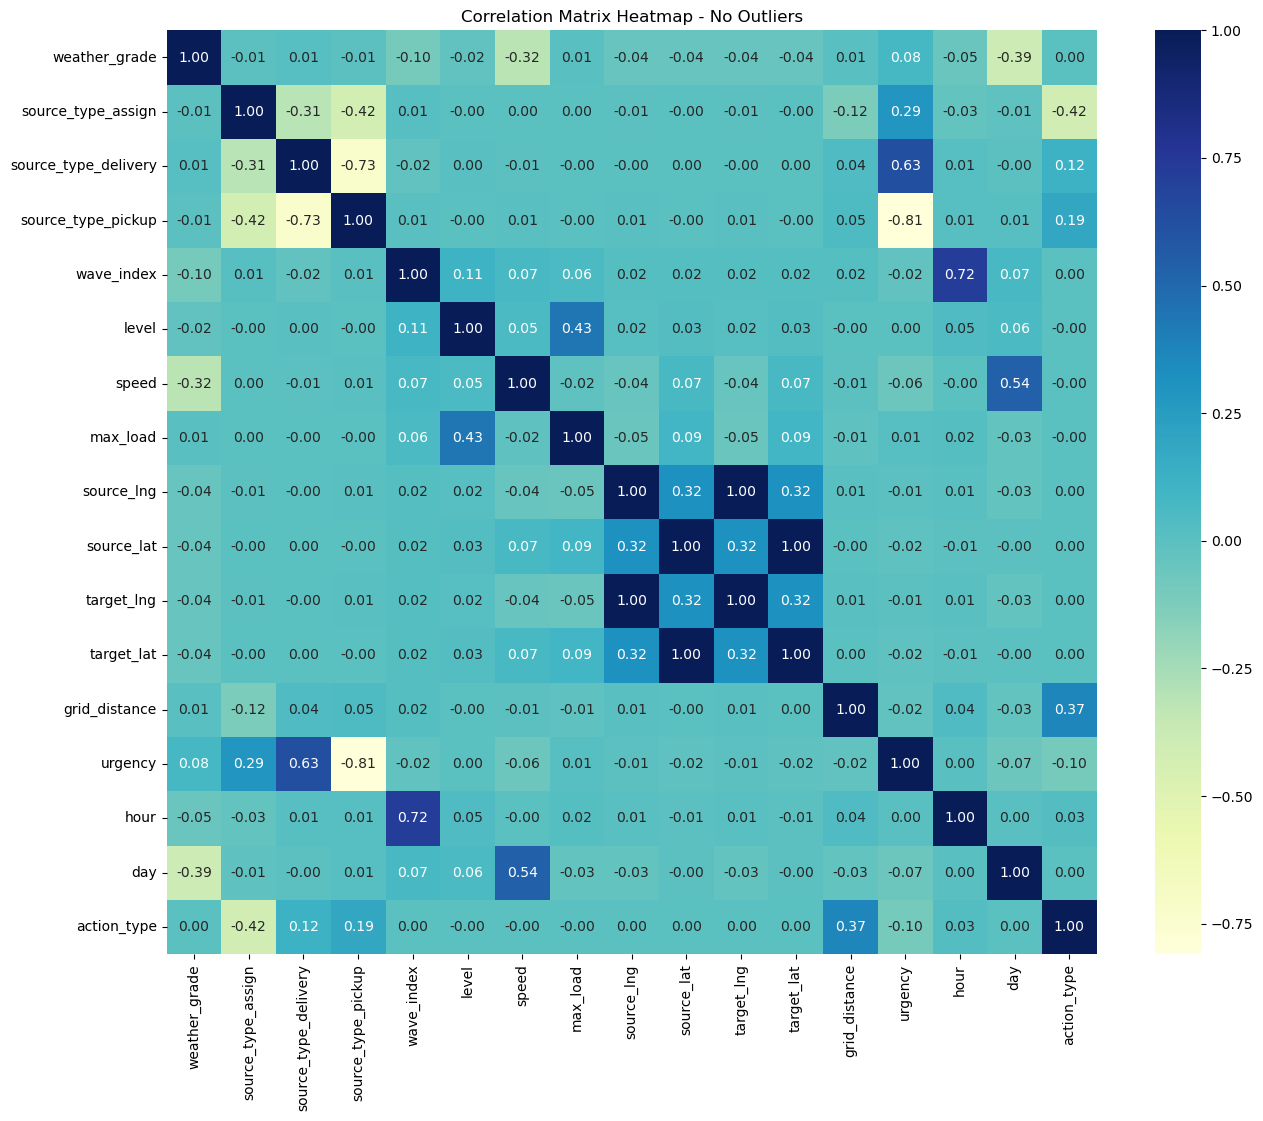

In [75]:
correlation_matrix = pd.concat([Xno_train.drop(columns=['year', 'month']), y1no_train], axis=1).corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Matrix Heatmap - No Outliers')
plt.show()

The transformed features perform better on correlation.

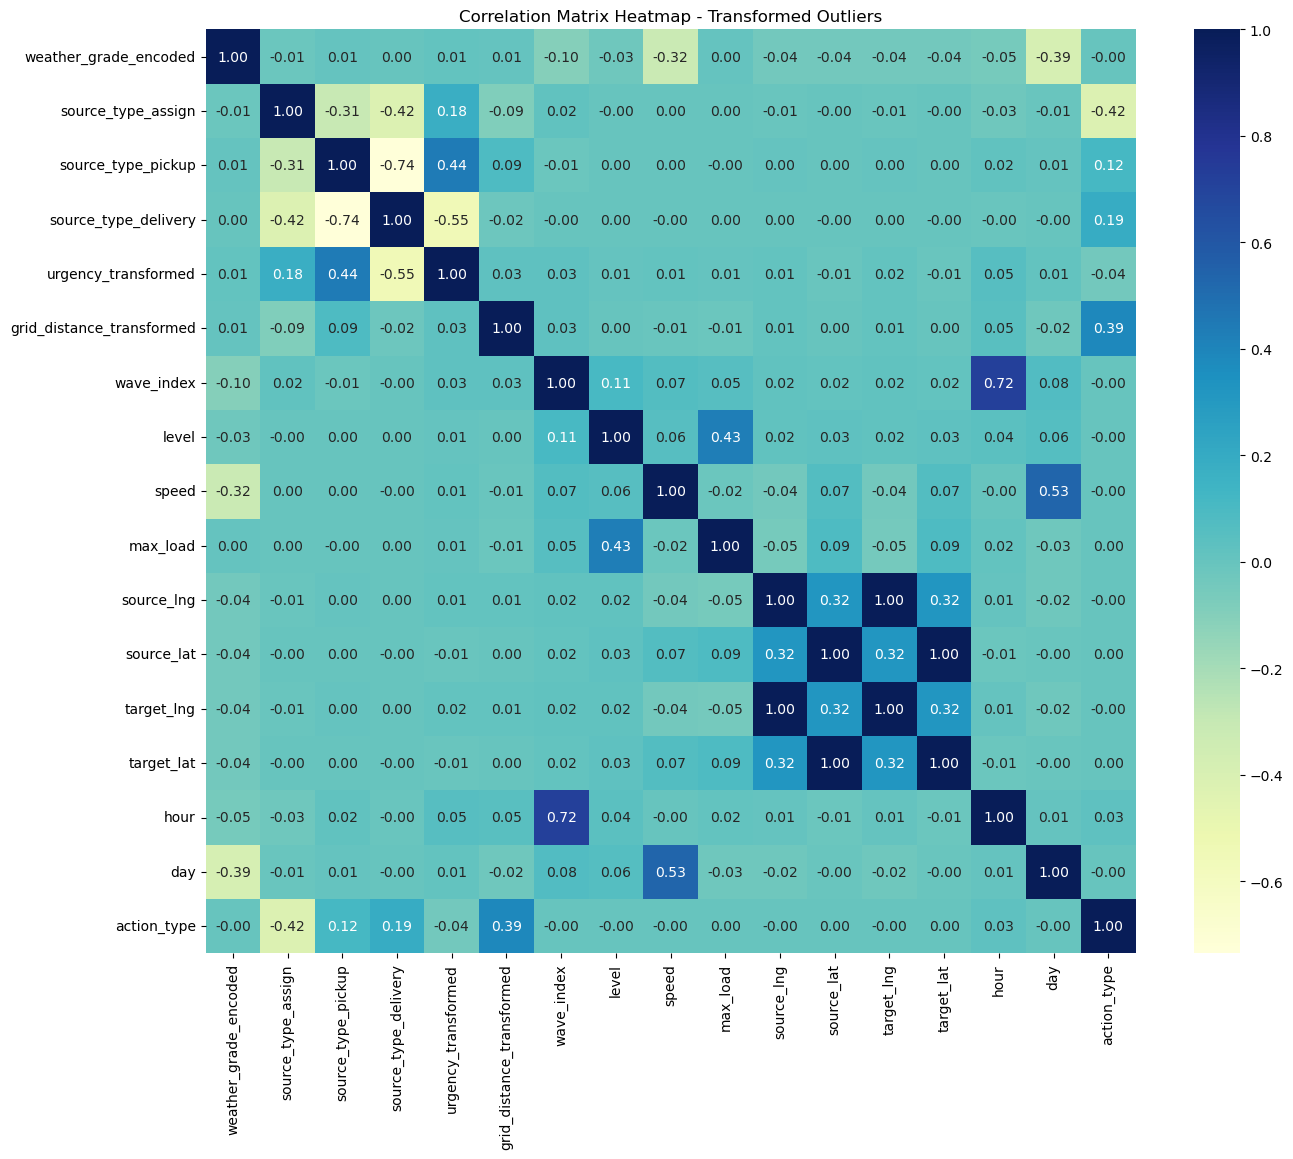

In [76]:
correlation_matrix = pd.concat([Xtr_train.drop(columns=['year', 'month']), y1tr_train], axis=1).corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Matrix Heatmap - Transformed Outliers')
plt.show()

### Data Modeling

In [77]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Xno_train_scaled = scaler.fit_transform(Xno_train)
Xno_val_scaled = scaler.transform(Xno_val)
Xno_test_scaled = scaler.transform(Xno_test)

Xtr_train_scaled = scaler.fit_transform(Xtr_train)
Xtr_val_scaled = scaler.transform(Xtr_val)
Xtr_test_scaled = scaler.transform(Xtr_test)

In [78]:
lr = LogisticRegression(max_iter=2000)
sgd_clf = SGDClassifier(max_iter=2000)
linear_svc = LinearSVC(max_iter=2000, dual='auto')
# svc = SVC(max_iter=2000)
knn_clf = KNeighborsClassifier(n_neighbors=5)
tree_clf = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)
rf_clf = RandomForestClassifier(max_depth=4, min_samples_leaf=5)
et_clf = ExtraTreesClassifier(max_depth=4, min_samples_leaf=5)
gb_clf = GradientBoostingClassifier(max_depth=4, min_samples_leaf=5)
xgb_clf = XGBClassifier()

In [79]:
def simple_classifier_cross_val(
        model, X_train, y_train
):
    ## Helper function to train a classifier with cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    formatted_scores = [f'{score:.2f}' for score in scores]
    formatted_mean_score = f'{scores.mean():.2f}'

    print("Accuracy scores for each fold:", formatted_scores)
    print("Mean Accuracy score:", formatted_mean_score)

Modeling Original Data

In [80]:
model_names = ['LogisticRegression', 'SGDClassifier', 'LinearSVC', 'KNeighborsClassifier','DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'XGBClassifier']
models = [lr, sgd_clf, linear_svc, knn_clf, tree_clf, rf_clf, et_clf, gb_clf, xgb_clf]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model, model_name in zip(models, model_names):
        if model_name in ['LogisticRegression', 'SGDClassifier', 'LinearSVC', 'KNeighborsClassifier']:
            print(model_name)
            simple_classifier_cross_val(model, X_train_scaled, y1_train)
            print('\n')
        else:
            print(model_name)
            simple_classifier_cross_val(model, X_train, y1_train)
            print('\n')

LogisticRegression


Accuracy scores for each fold: ['0.73', '0.73', '0.73', '0.73', '0.73']
Mean Accuracy score: 0.73


SGDClassifier
Accuracy scores for each fold: ['0.72', '0.72', '0.72', '0.72', '0.73']
Mean Accuracy score: 0.72


LinearSVC
Accuracy scores for each fold: ['0.73', '0.73', '0.73', '0.73', '0.73']
Mean Accuracy score: 0.73


KNeighborsClassifier
Accuracy scores for each fold: ['0.73', '0.73', '0.73', '0.73', '0.73']
Mean Accuracy score: 0.73


DecisionTreeClassifier
Accuracy scores for each fold: ['0.78', '0.78', '0.78', '0.75', '0.75']
Mean Accuracy score: 0.77


RandomForestClassifier
Accuracy scores for each fold: ['0.77', '0.76', '0.76', '0.76', '0.76']
Mean Accuracy score: 0.76


ExtraTreesClassifier
Accuracy scores for each fold: ['0.65', '0.65', '0.65', '0.65', '0.65']
Mean Accuracy score: 0.65


GradientBoostingClassifier
Accuracy scores for each fold: ['0.80', '0.80', '0.79', '0.80', '0.80']
Mean Accuracy score: 0.80


XGBClassifier
Accuracy scores for each fold: ['0.85', '0.85',

In [81]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[X_train_scaled.shape[1],]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                 beta_1=0.9, beta_2=0.999),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y1_train, epochs=5,
                    validation_data=(X_val_scaled, y1_val))

Epoch 1/5
10193/10193 [==============================] - 262s 25ms/step - loss: 0.6969 - accuracy: 0.4991 - val_loss: 0.6933 - val_accuracy: 0.4988
Epoch 2/5
10193/10193 [==============================] - 224s 22ms/step - loss: 0.6933 - accuracy: 0.4987 - val_loss: 0.6932 - val_accuracy: 0.5012
Epoch 3/5
10193/10193 [==============================] - 237s 23ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 4/5
10193/10193 [==============================] - 276s 27ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5012
Epoch 5/5
10193/10193 [==============================] - 275s 27ms/step - loss: 0.6932 - accuracy: 0.5001 - val_loss: 0.6933 - val_accuracy: 0.4988


#### Feature Importance

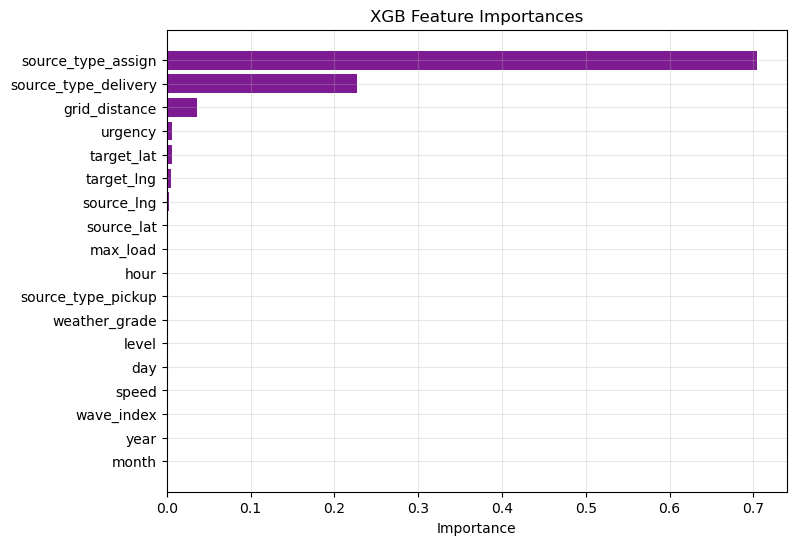

In [82]:
# Build the model
model = XGBClassifier()
model.fit(X_train, y1_train)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1],
)
plt.xlabel('Importance')
plt.title('XGB Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()


Selected Features:  Index(['source_type_assign', 'source_type_delivery', 'source_type_pickup'], dtype='object')


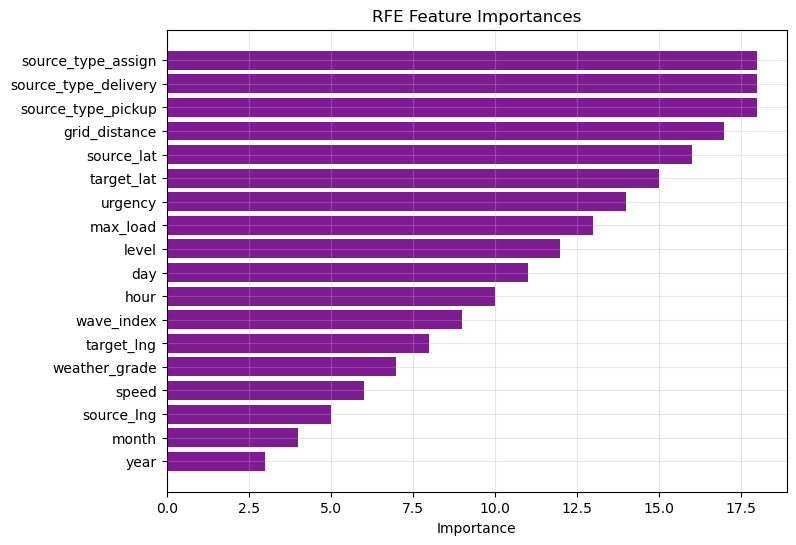

In [83]:
# Build the model
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=3) # select top 3 features
fit = rfe.fit(X_train_scaled, y1_train)

print("Selected Features: ", X_train.columns[fit.support_])

inverted_ranking = len(rfe.ranking_) - rfe.ranking_ + 1
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': inverted_ranking})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('RFE Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Selected Features:  Index(['source_type_assign', 'source_type_pickup', 'grid_distance'], dtype='object')


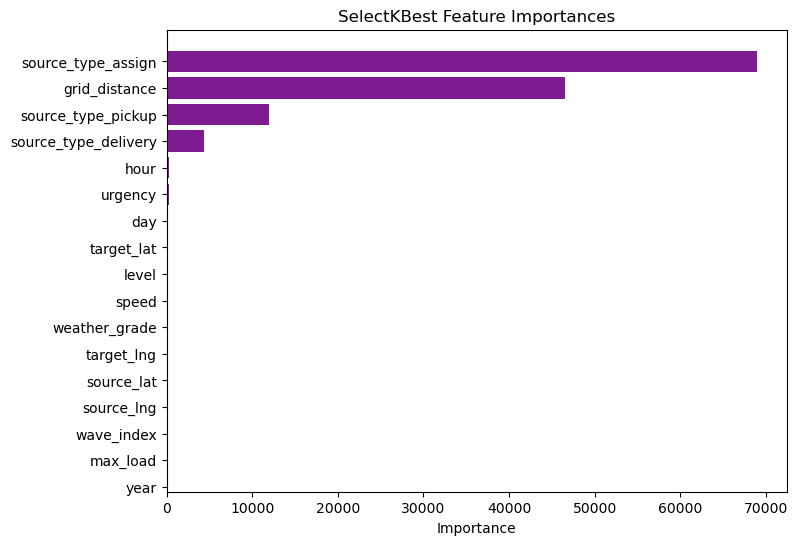

In [84]:
# Create an instance of SelectKBest with chi2 scoring function
selector = SelectKBest(f_classif, k=3)

# Fit the selector on the training set
X_train_selected = selector.fit_transform(X_train, y1_train)

# Print the selected features
print("Selected Features: ", X_train.columns[selector.get_support()])

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': selector.scores_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('SelectKBest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

From all the model feature selectors, the most important features for action type are source type, grid distance, urgency, source and target location and hour. 

Modeling Regressor Target Variable: Expected Use Time

In [85]:
lr_reg = LinearRegression()
sgd_reg = SGDRegressor(max_iter=2000)
linear_svr = LinearSVR(max_iter=2000, dual='auto')
ridge_reg = Ridge()
lasso_reg = Lasso()
knn_reg = KNeighborsRegressor(n_neighbors=5)
tree_reg = DecisionTreeRegressor(max_depth=4, min_samples_leaf=5)
rf_reg = RandomForestRegressor(max_depth=4, min_samples_leaf=5)
et_reg = ExtraTreesRegressor(max_depth=4, min_samples_leaf=5)
gb_reg = GradientBoostingRegressor(max_depth=4, min_samples_leaf=5)
xgb_reg = XGBRegressor()

In [86]:
def simple_regressor_cross_val(model, X_train, y_train):
    ## Helper function to train a classifier with cross-validation
    scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    formatted_scores = [f'{score:.2f}' for score in scores]
    formatted_mean_score = f'{scores.mean():.2f}'

    print("MAE scores for each fold:", formatted_scores)
    print("Mean MAE score:", formatted_mean_score)

In [87]:
model_names = ['LinearRegression', 'SGDRegressor', 'LinearSVR', 'RidgeRegression', 'LassoRegression', 'KNeighborsRegressor','DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
models = [lr_reg, sgd_reg, linear_svr, ridge_reg, lasso_reg, knn_reg, tree_reg, rf_reg, et_reg, gb_reg, xgb_reg]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model, model_name in zip(models, model_names):
        if model_name in ['LinearRegression', 'SGDRegressor', 'LinearSVR', 'RidgeRegression', 'LassoRegression', 'KNeighborsRegressor']:
            print(model_name)
            simple_regressor_cross_val(model, X_train_scaled, y2_train)
            print('\n')
        else:
            print(model_name)
            simple_regressor_cross_val(model, X_train, y2_train)
            print('\n')

LinearRegression


MAE scores for each fold: ['215.28', '214.51', '215.16', '215.33', '215.36']
Mean MAE score: 215.13


SGDRegressor
MAE scores for each fold: ['215.49', '214.94', '215.55', '215.89', '215.40']
Mean MAE score: 215.45


LinearSVR
MAE scores for each fold: ['203.52', '202.67', '203.32', '202.78', '203.51']
Mean MAE score: 203.16


RidgeRegression
MAE scores for each fold: ['215.29', '214.50', '215.16', '215.33', '215.35']
Mean MAE score: 215.13


LassoRegression
MAE scores for each fold: ['215.32', '214.60', '215.23', '215.35', '215.43']
Mean MAE score: 215.19


KNeighborsRegressor
MAE scores for each fold: ['225.02', '225.22', '225.50', '224.71', '225.82']
Mean MAE score: 225.25


DecisionTreeRegressor
MAE scores for each fold: ['205.86', '206.05', '206.55', '206.01', '207.14']
Mean MAE score: 206.32


RandomForestRegressor
MAE scores for each fold: ['204.51', '203.27', '204.10', '204.72', '205.01']
Mean MAE score: 204.32


ExtraTreesRegressor
MAE scores for each fold: ['219.05', '217.00'

### Feature Importance

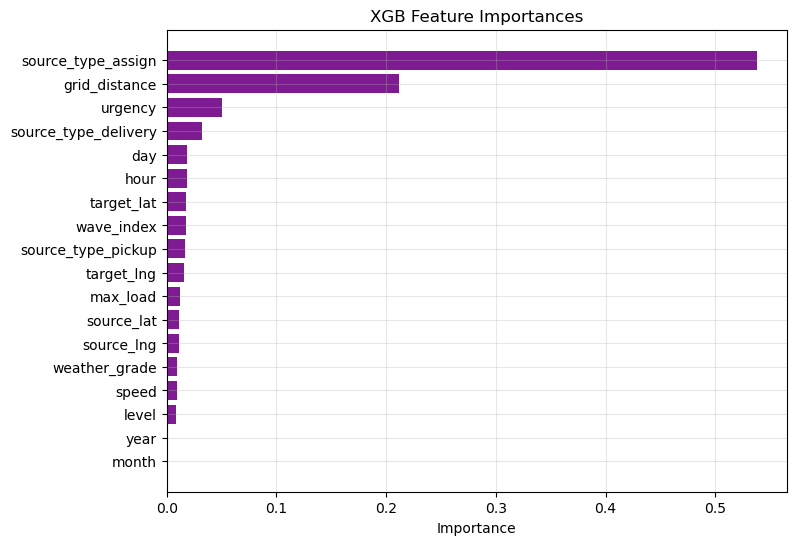

In [88]:
# Build the model
model = XGBRegressor()
model.fit(X_train, y2_train)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1],
)
plt.xlabel('Importance')
plt.title('XGB Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()


Selected Features:  Index(['source_type_assign', 'source_type_pickup', 'grid_distance'], dtype='object')


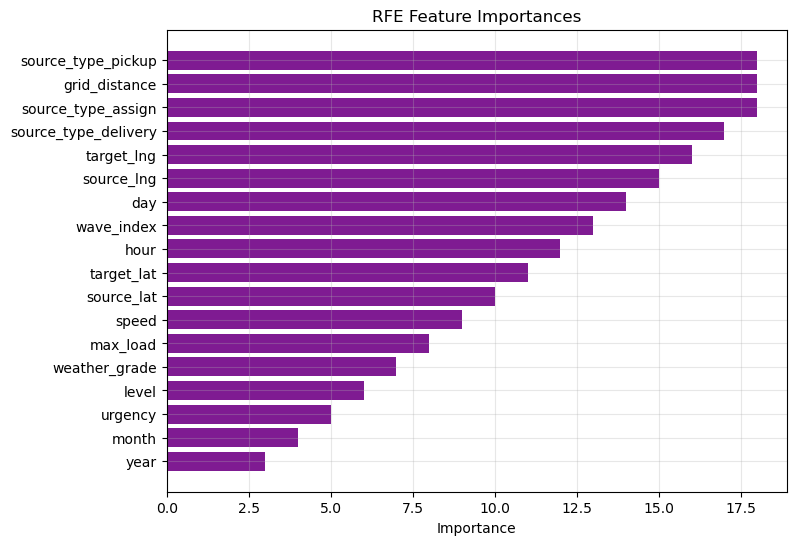

In [89]:
# Build the model
model = LinearSVR(max_iter=2000, dual='auto')
rfe = RFE(model, n_features_to_select=3) # select top 3 features
fit = rfe.fit(X_train_scaled, y2_train)

print("Selected Features: ", X_train.columns[fit.support_])

inverted_ranking = len(rfe.ranking_) - rfe.ranking_ + 1
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': inverted_ranking})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('RFE Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()

Selected Features:  Index(['source_type_assign', 'source_type_pickup', 'grid_distance'], dtype='object')


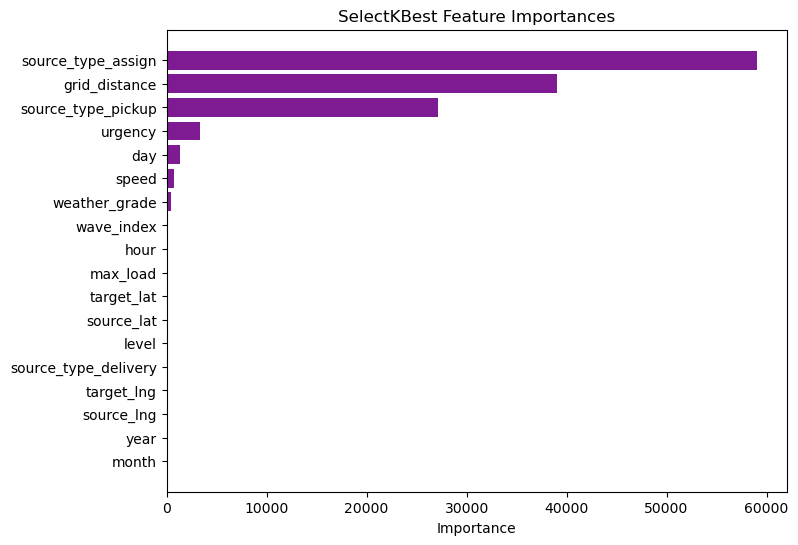

In [90]:
# Create an instance of SelectKBest with chi2 scoring function
selector = SelectKBest(f_regression, k=3)

# Fit the selector on the training set
X_train_selected = selector.fit_transform(X_train, y2_train)

# Print the selected features
print("Selected Features: ", X_train.columns[selector.get_support()])

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': selector.scores_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('SelectKBest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In addition to the action type important features, important features for expected use time include day and speed.

In conclusion, when modeling the original dataset, we will use the following features: `['source_type_assign', 'source_type_delivery', 'source_type_pickup', 'grid_distance', 'urgency', 'source_lng', 'source_lat', 'target_lat', 'target_lng', 'hour', 'day', 'speed']`.

Modeling without Outliers

In [91]:
model_names = ['LogisticRegression', 'SGDClassifier', 'LinearSVC', 'KNeighborsClassifier','DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'XGBClassifier']
models = [lr, sgd_clf, linear_svc, knn_clf, tree_clf, rf_clf, et_clf, gb_clf, xgb_clf]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model, model_name in zip(models, model_names):
        if model_name in ['LogisticRegression', 'SGDClassifier', 'LinearSVC', 'KNeighborsClassifier']:
            print(model_name)
            simple_classifier_cross_val(model, Xno_train_scaled, y1no_train)
            print('\n')
        else:
            print(model_name)
            simple_classifier_cross_val(model, Xno_train, y1no_train)
            print('\n')

LogisticRegression
Accuracy scores for each fold: ['0.73', '0.73', '0.73', '0.73', '0.73']
Mean Accuracy score: 0.73


SGDClassifier
Accuracy scores for each fold: ['0.73', '0.72', '0.72', '0.73', '0.73']
Mean Accuracy score: 0.72


LinearSVC
Accuracy scores for each fold: ['0.73', '0.73', '0.73', '0.73', '0.73']
Mean Accuracy score: 0.73


KNeighborsClassifier
Accuracy scores for each fold: ['0.74', '0.74', '0.74', '0.73', '0.74']
Mean Accuracy score: 0.74


DecisionTreeClassifier
Accuracy scores for each fold: ['0.75', '0.75', '0.75', '0.77', '0.75']
Mean Accuracy score: 0.76


RandomForestClassifier
Accuracy scores for each fold: ['0.77', '0.75', '0.77', '0.76', '0.77']
Mean Accuracy score: 0.77


ExtraTreesClassifier
Accuracy scores for each fold: ['0.75', '0.75', '0.75', '0.75', '0.76']
Mean Accuracy score: 0.75


GradientBoostingClassifier
Accuracy scores for each fold: ['0.79', '0.79', '0.79', '0.79', '0.79']
Mean Accuracy score: 0.79


XGBClassifier
Accuracy scores for each fol

### Feature Importance

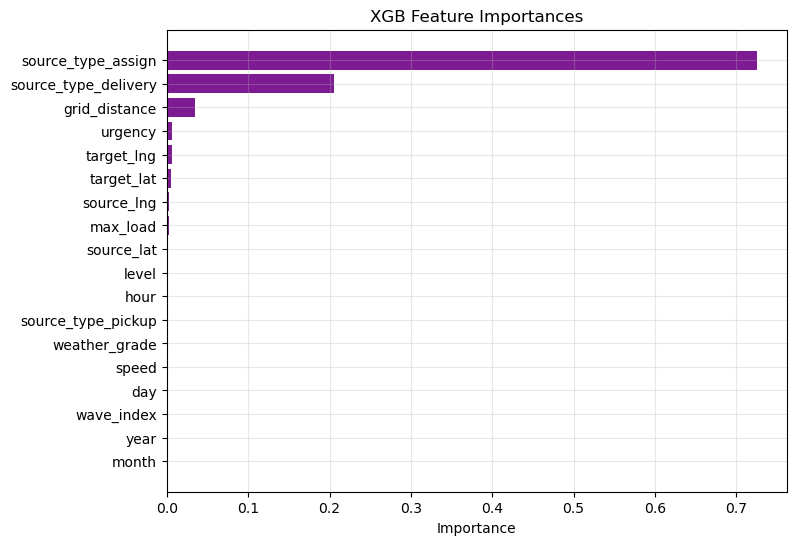

In [92]:
# Build the model
model = XGBClassifier()
model.fit(Xno_train, y1no_train)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': Xno_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1],
)
plt.xlabel('Importance')
plt.title('XGB Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()


Selected Features:  Index(['source_type_assign', 'source_type_delivery', 'source_type_pickup'], dtype='object')


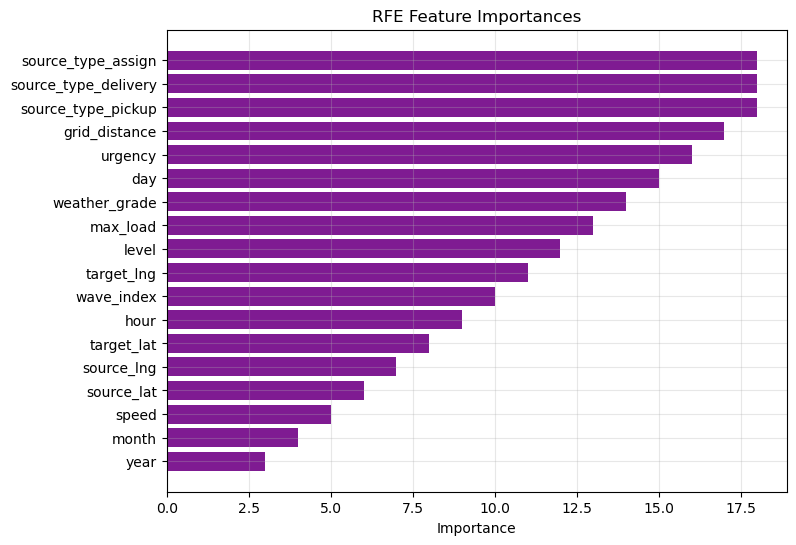

In [93]:
# Build the model
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=3) # select top 3 features
fit = rfe.fit(Xno_train_scaled, y1no_train)

print("Selected Features: ", Xno_train.columns[fit.support_])

inverted_ranking = len(rfe.ranking_) - rfe.ranking_ + 1
feature_importance_df = pd.DataFrame({'Feature': Xno_train.columns, 'Importance': inverted_ranking})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('RFE Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()

Selected Features:  Index(['source_type_assign', 'source_type_pickup', 'grid_distance'], dtype='object')


/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


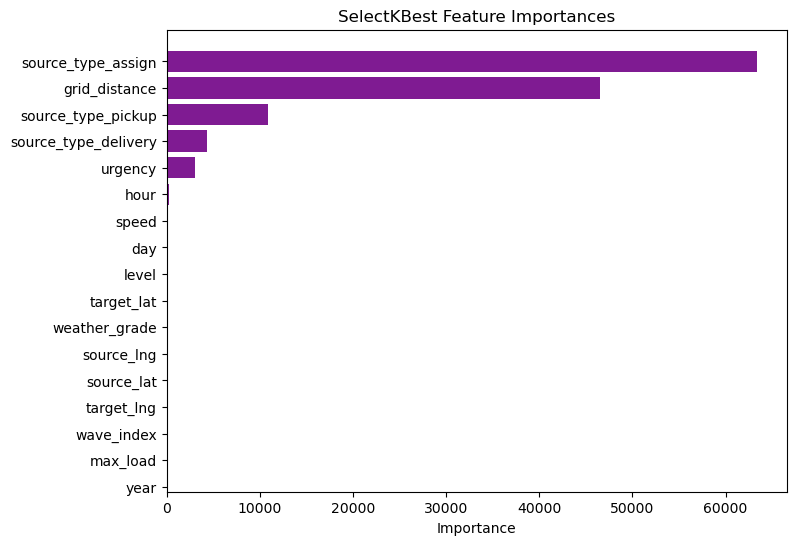

In [94]:
# Create an instance of SelectKBest with chi2 scoring function
selector = SelectKBest(f_classif, k=3)

# Fit the selector on the training set
X_train_selected = selector.fit_transform(Xno_train, y1no_train)

# Print the selected features
print("Selected Features: ", Xno_train.columns[selector.get_support()])

feature_importance_df = pd.DataFrame({'Feature': Xno_train.columns, 'Importance': selector.scores_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('SelectKBest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Modeling the Regressor Variable with the No Outliers Dataset

In [95]:
model_names = ['LinearRegression', 'SGDRegressor', 'LinearSVR', 'Ridge', 'Lasso', 'KNeighborsRegressor','DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
models = [lr_reg, sgd_reg, linear_svr, ridge_reg, lasso_reg, knn_reg, tree_reg, rf_reg, et_reg, gb_reg, xgb_reg]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model, model_name in zip(models, model_names):
        if model_name in ['LinearRegression', 'SGDRegressor', 'LinearSVR', 'Ridge', 'Lasso', 'KNeighborsRegressor']:
            print(model_name)
            simple_regressor_cross_val(model, Xno_train_scaled, y2no_train)
            print('\n')
        else:
            print(model_name)
            simple_regressor_cross_val(model, Xno_train, y2no_train)
            print('\n')

LinearRegression
MAE scores for each fold: ['206.56', '206.33', '207.53', '206.98', '206.33']
Mean MAE score: 206.74


SGDRegressor
MAE scores for each fold: ['206.29', '205.33', '206.57', '206.73', '206.59']
Mean MAE score: 206.30


LinearSVR
MAE scores for each fold: ['194.81', '194.74', '196.84', '195.88', '195.12']
Mean MAE score: 195.48


Ridge
MAE scores for each fold: ['206.56', '206.29', '207.52', '206.95', '206.32']
Mean MAE score: 206.73


Lasso
MAE scores for each fold: ['206.63', '206.35', '207.57', '207.04', '206.38']
Mean MAE score: 206.79


KNeighborsRegressor
MAE scores for each fold: ['213.04', '213.72', '214.72', '215.32', '213.46']
Mean MAE score: 214.05


DecisionTreeRegressor
MAE scores for each fold: ['198.35', '198.32', '198.80', '198.46', '197.72']
Mean MAE score: 198.33


RandomForestRegressor
MAE scores for each fold: ['196.79', '197.08', '197.89', '197.46', '196.81']
Mean MAE score: 197.21


ExtraTreesRegressor
MAE scores for each fold: ['200.58', '201.04', '

Feature Importance

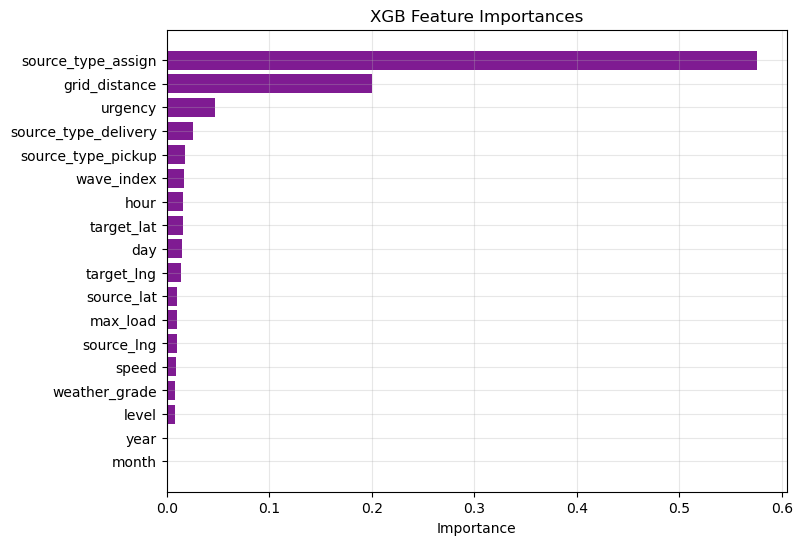

In [96]:
# Build the model
model = XGBRegressor()
model.fit(Xno_train, y2no_train)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': Xno_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1],
)
plt.xlabel('Importance')
plt.title('XGB Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()


Selected Features:  Index(['source_type_assign', 'source_type_pickup', 'grid_distance'], dtype='object')


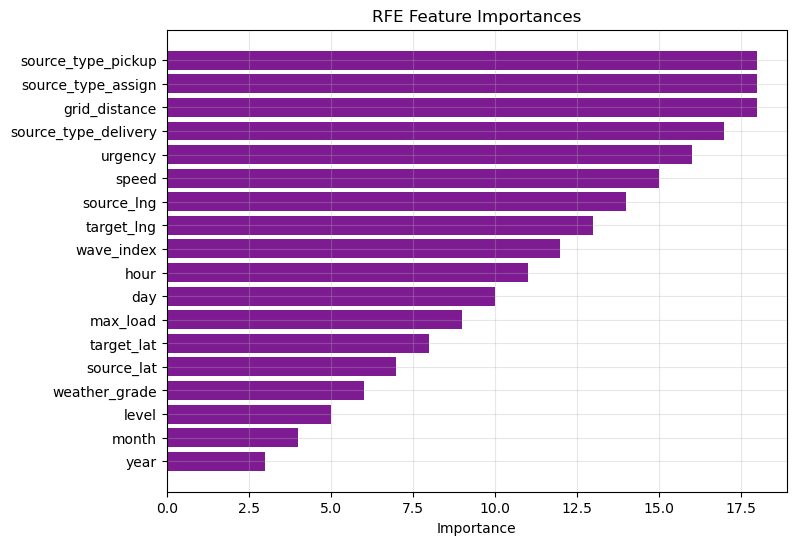

In [97]:
# Build the model
model = LinearSVR(max_iter=1000, dual='auto')
rfe = RFE(model, n_features_to_select=3) # select top 3 features
fit = rfe.fit(Xno_train_scaled, y2no_train)

print("Selected Features: ", Xno_train.columns[fit.support_])

inverted_ranking = len(rfe.ranking_) - rfe.ranking_ + 1
feature_importance_df = pd.DataFrame({'Feature': Xno_train.columns, 'Importance': inverted_ranking})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('RFE Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()

Selected Features:  Index(['source_type_assign', 'source_type_pickup', 'grid_distance'], dtype='object')


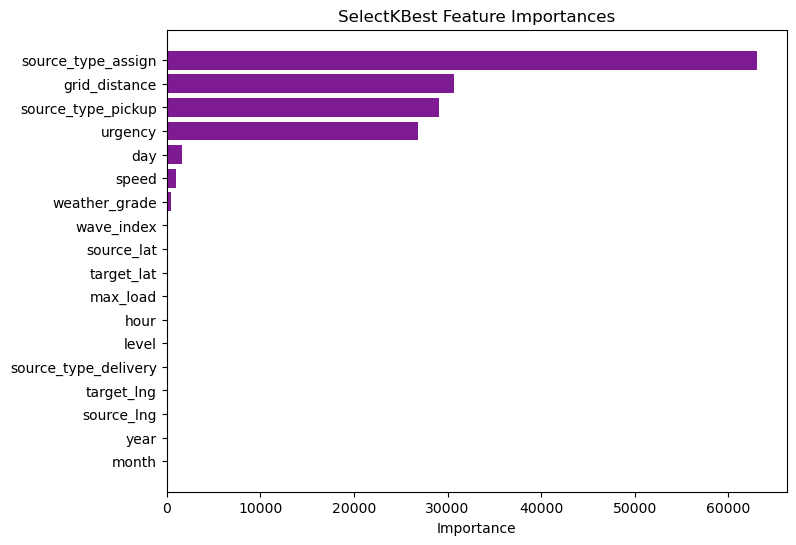

In [98]:
# Create an instance of SelectKBest with chi2 scoring function
selector = SelectKBest(f_regression, k=3)

# Fit the selector on the training set
X_train_selected = selector.fit_transform(Xno_train, y2no_train)

# Print the selected features
print("Selected Features: ", Xno_train.columns[selector.get_support()])

feature_importance_df = pd.DataFrame({'Feature': Xno_train.columns, 'Importance': selector.scores_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('SelectKBest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Modeling Transformed Outliers

In [99]:
model_names = ['LogisticRegression', 'SGDClassifier', 'LinearSVC', 'KNeighborsClassifier','DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'XGBClassifier']
models = [lr, sgd_clf, linear_svc, knn_clf, tree_clf, rf_clf, et_clf, gb_clf, xgb_clf]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model, model_name in zip(models, model_names):
        if model_name in ['LogisticRegression', 'SGDClassifier', 'LinearSVC', 'KNeighborsClassifier']:
            print(model_name)
            simple_classifier_cross_val(model, Xtr_train_scaled, y1tr_train)
            print('\n')
        else:
            print(model_name)
            simple_classifier_cross_val(model, Xtr_train, y1tr_train)
            print('\n')

LogisticRegression
Accuracy scores for each fold: ['0.74', '0.74', '0.74', '0.74', '0.74']
Mean Accuracy score: 0.74


SGDClassifier
Accuracy scores for each fold: ['0.74', '0.73', '0.74', '0.74', '0.74']
Mean Accuracy score: 0.74


LinearSVC
Accuracy scores for each fold: ['0.74', '0.73', '0.74', '0.74', '0.74']
Mean Accuracy score: 0.74


KNeighborsClassifier
Accuracy scores for each fold: ['0.75', '0.75', '0.75', '0.75', '0.75']
Mean Accuracy score: 0.75


DecisionTreeClassifier
Accuracy scores for each fold: ['0.78', '0.78', '0.78', '0.75', '0.75']
Mean Accuracy score: 0.77


RandomForestClassifier
Accuracy scores for each fold: ['0.76', '0.76', '0.76', '0.76', '0.76']
Mean Accuracy score: 0.76


ExtraTreesClassifier
Accuracy scores for each fold: ['0.74', '0.74', '0.73', '0.74', '0.74']
Mean Accuracy score: 0.74


GradientBoostingClassifier
Accuracy scores for each fold: ['0.80', '0.80', '0.79', '0.80', '0.80']
Mean Accuracy score: 0.80


XGBClassifier
Accuracy scores for each fol

Feature Importance:

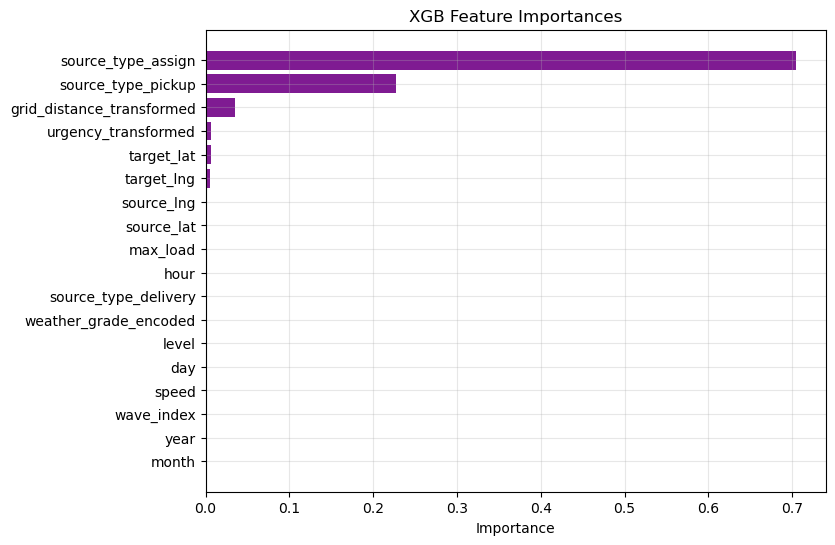

In [100]:
# Build the model
model = XGBClassifier()
model.fit(Xtr_train, y1tr_train)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': Xtr_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1],
)
plt.xlabel('Importance')
plt.title('XGB Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()


Selected Features:  Index(['source_type_assign', 'source_type_pickup', 'source_type_delivery'], dtype='object')


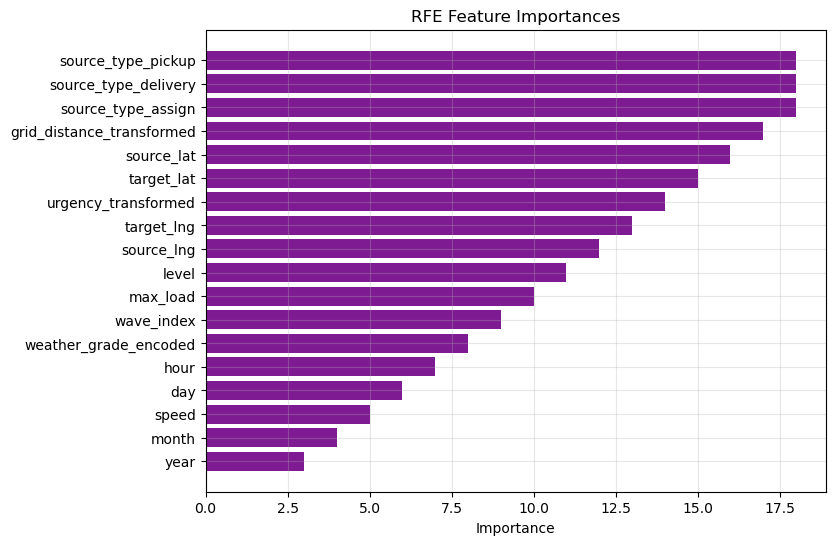

In [101]:
# Build the model
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=3) # select top 3 features
fit = rfe.fit(Xtr_train_scaled, y1tr_train)

print("Selected Features: ", Xtr_train.columns[fit.support_])

inverted_ranking = len(rfe.ranking_) - rfe.ranking_ + 1
feature_importance_df = pd.DataFrame({'Feature': Xtr_train.columns, 'Importance': inverted_ranking})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('RFE Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()

Selected Features:  Index(['source_type_assign', 'source_type_delivery',
       'grid_distance_transformed'],
      dtype='object')


/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [15 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp2/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


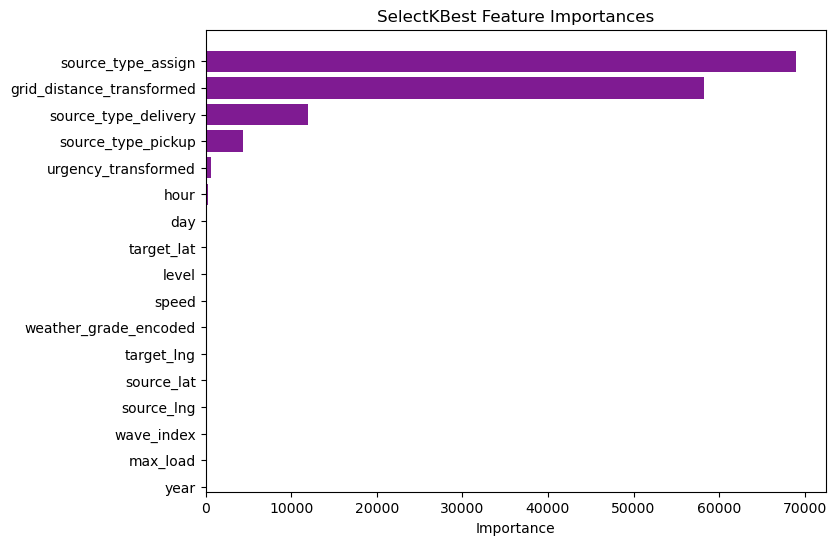

In [102]:
# Create an instance of SelectKBest with chi2 scoring function
selector = SelectKBest(f_classif, k=3)

# Fit the selector on the training set
X_train_selected = selector.fit_transform(Xtr_train, y1tr_train)

# Print the selected features
print("Selected Features: ", Xtr_train.columns[selector.get_support()])

feature_importance_df = pd.DataFrame({'Feature': Xtr_train.columns, 'Importance': selector.scores_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('SelectKBest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [103]:
model_names = ['LinearRegression', 'SGDRegressor', 'LinearSVR', 'Ridge', 'Lasso', 'KNeighborsRegressor','DecisionTreeRegressor', 'RandomForestRegressor', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
models = [lr_reg, sgd_reg, linear_svr, ridge_reg, lasso_reg, knn_reg, tree_reg, rf_reg, et_reg, gb_reg, xgb_reg]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model, model_name in zip(models, model_names):
        if model_name in ['LinearRegression', 'SGDRegressor', 'LinearSVR', 'Ridge', 'Lasso', 'KNeighborsRegressor']:
            print(model_name)
            simple_regressor_cross_val(model, Xtr_train_scaled, y2tr_train)
            print('\n')
        else:
            print(model_name)
            simple_regressor_cross_val(model, Xtr_train, y2tr_train)
            print('\n')

LinearRegression
MAE scores for each fold: ['210.41', '209.55', '210.39', '210.79', '210.80']
Mean MAE score: 210.39


SGDRegressor
MAE scores for each fold: ['211.63', '209.60', '211.12', '213.27', '212.16']
Mean MAE score: 211.55


LinearSVR
MAE scores for each fold: ['197.97', '196.99', '198.00', '197.34', '198.24']
Mean MAE score: 197.71


Ridge
MAE scores for each fold: ['210.42', '209.56', '210.39', '210.79', '210.80']
Mean MAE score: 210.39


Lasso
MAE scores for each fold: ['210.39', '209.57', '210.40', '210.78', '210.80']
Mean MAE score: 210.39


KNeighborsRegressor
MAE scores for each fold: ['218.94', '219.06', '219.50', '219.71', '220.32']
Mean MAE score: 219.50


DecisionTreeRegressor
MAE scores for each fold: ['205.86', '206.05', '206.55', '206.01', '207.14']
Mean MAE score: 206.32


RandomForestRegressor
MAE scores for each fold: ['204.48', '203.47', '203.98', '204.63', '205.12']
Mean MAE score: 204.33


ExtraTreesRegressor
MAE scores for each fold: ['211.09', '211.49', '

Feature Importance:

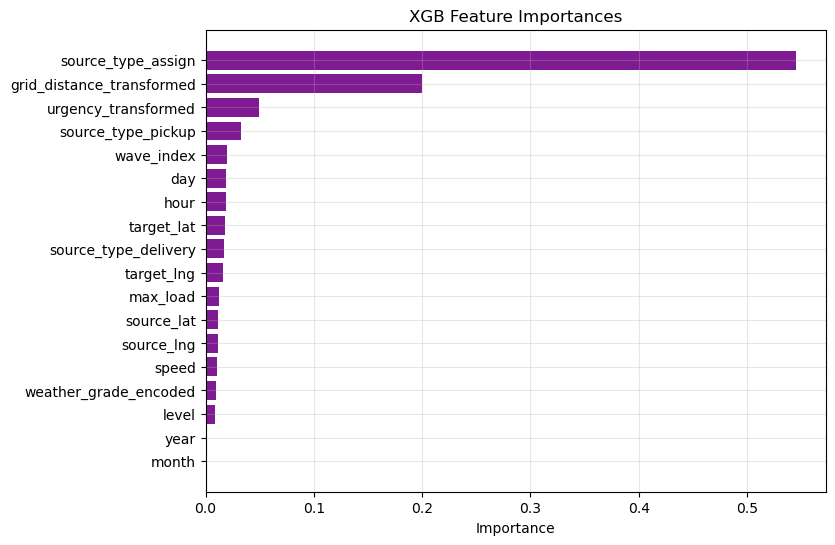

In [104]:
# Build the model
model = XGBRegressor()
model.fit(Xtr_train, y2tr_train)
feature_importance = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': Xtr_train.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1],
)
plt.xlabel('Importance')
plt.title('XGB Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()


Selected Features:  Index(['source_type_assign', 'source_type_delivery',
       'grid_distance_transformed'],
      dtype='object')


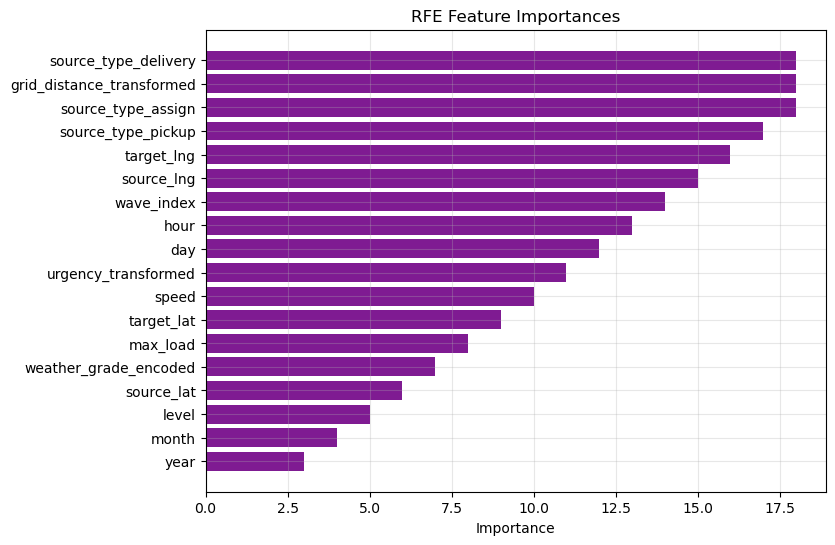

In [105]:
# Build the model
model = LinearSVR(max_iter=2000, dual='auto')
rfe = RFE(model, n_features_to_select=3) # select top 3 features
fit = rfe.fit(Xtr_train_scaled, y2tr_train)

print("Selected Features: ", Xtr_train.columns[fit.support_])

inverted_ranking = len(rfe.ranking_) - rfe.ranking_ + 1
feature_importance_df = pd.DataFrame({'Feature': Xtr_train.columns, 'Importance': inverted_ranking})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('RFE Feature Importances')
plt.gca().invert_yaxis()
plt.grid(alpha=.3)
plt.show()

Selected Features:  Index(['source_type_assign', 'source_type_delivery',
       'grid_distance_transformed'],
      dtype='object')


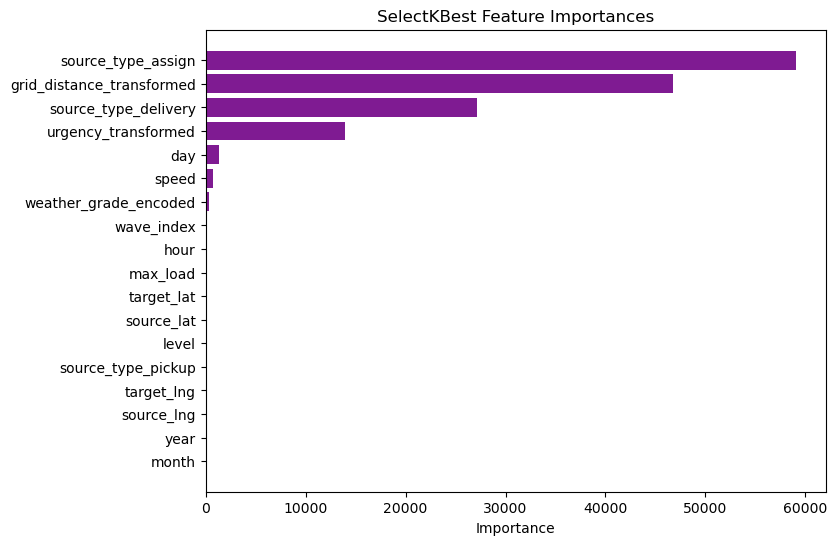

In [106]:
# Create an instance of SelectKBest with chi2 scoring function
selector = SelectKBest(f_regression, k=3)

# Fit the selector on the training set
X_train_selected = selector.fit_transform(Xtr_train, y2tr_train)

# Print the selected features
print("Selected Features: ", Xtr_train.columns[selector.get_support()])

feature_importance_df = pd.DataFrame({'Feature': Xtr_train.columns, 'Importance': selector.scores_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(
    feature_importance_df['Feature'], feature_importance_df['Importance'], color=deep_colors[1]
)
plt.xlabel('Importance')
plt.title('SelectKBest Feature Importances')
plt.gca().invert_yaxis()
plt.show()

### Hyperparameter Tuning 

We'll tune the XGB model to try to increase evaluation scores.

In [107]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.6, 0.8],
    'subsample': [0.6, 0.8],
}

# Initialize XGBClassifier
xgb_clf = XGBClassifier()

# grid_search = GridSearchCV(xgb_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
random_search = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, cv=5, scoring='accuracy', n_jobs=-1, n_iter=50, verbose=2)

# grid_search.fit(X_train, y1_train)
random_search.fit(X_train, y1_train)

# best_params = grid_search.best_params_
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_
best_score = random_search.best_score_

print(f'best params: {best_params}')
print(f'\nbest estimator: {best_estimator}')
print(f'\nbest score: {best_score}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   4.7s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   4.9s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   5.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.6; total time=   5.4s
[CV] END colsample

In [108]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'colsample_bytree': [0.6, 0.8],
    'subsample': [0.6, 0.8],
}

xgb_reg = XGBRegressor()
random_search = RandomizedSearchCV(xgb_reg, param_distributions=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, n_iter=50, verbose=2)
random_search.fit(X_train, y2_train)

best_params = random_search.best_params_
best_estimator = random_search.best_estimator_
best_score = random_search.best_score_

print(f'best params: {best_params}')
print(f'\nbest estimator: {best_estimator}')
print(f'\nbest score: {best_score}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.9s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   4.0s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   4.1s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.8; total time=   4.6s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.8; total time=   4.8s
[CV] END colsample_bytree=0.8, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.8; total time=   4.9s
[CV] END colsample_bytree=0.6, learning_rate=0.2, max_depth=3, n_estimators=100,

### Model Evaluation

In [109]:
model = XGBClassifier(
    subsample=.8, n_estimators=300, max_depth=5, 
    learning_rate=.3, colsample_bytree=.8
)
model.fit(X_train, y1_train)
y1_pred = model.predict(X_val)

print(classification_report(y1_val, y1_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85     40674
         1.0       0.83      0.89      0.86     40863

    accuracy                           0.86     81537
   macro avg       0.86      0.86      0.86     81537
weighted avg       0.86      0.86      0.86     81537



In [110]:
y1_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for class 1
threshold = 0.5 # Choose a threshold value (e.g., 0.5 by default)
y1_pred_adjusted = (y1_pred_proba >= threshold).astype(int)

print(classification_report(y1_val, y1_pred_adjusted))

              precision    recall  f1-score   support

         0.0       0.89      0.82      0.85     40674
         1.0       0.83      0.89      0.86     40863

    accuracy                           0.86     81537
   macro avg       0.86      0.86      0.86     81537
weighted avg       0.86      0.86      0.86     81537



In [112]:
model = XGBRegressor(
    subsample=.8, n_estimators=300, max_depth=5,
    learning_rate=.2, colsample_bytree=.8
)
model.fit(X_train, y2_train)
y2_pred = model.predict(X_val)

print(mean_absolute_error(y2_val, y2_pred))

196.3944697655329


In [113]:
# Predicting Expected Use Time by including actual action type values
X_val2 = pd.concat([X_val, y1_val], axis=1)
X_test2 = pd.concat([X_test, y1_test], axis=1)

model = XGBRegressor(
    subsample=.8, n_estimators=300, max_depth=5,
    learning_rate=.2, colsample_bytree=.8
)
model.fit(X_val2, y2_val)
y2_pred = model.predict(X_test2)

print(mean_absolute_error(y2_test, y2_pred))

191.34207681718053


In [114]:
# Predicting Expected Use Time by including predicted action type values
X_val2 = X_val.copy()
X_val2['action_type'] = y1_pred
X_test2 = pd.concat([X_test, y1_test], axis=1)

model = XGBRegressor(
    subsample=.8, n_estimators=300, max_depth=5,
    learning_rate=.2, colsample_bytree=.8
)
model.fit(X_val2, y2_val)
y2_pred = model.predict(X_test2)

print(mean_absolute_error(y2_test, y2_pred))

194.72383353418823


Limit Training Data to Relevant Columns from Feature Importance

In [115]:
rel_cols = ['source_type_assign', 'source_type_delivery', 'source_type_pickup', 'grid_distance', 'urgency', 'source_lng', 'source_lat', 'target_lat', 'target_lng', 'hour', 'day', 'speed']

model = XGBClassifier(
    subsample=.8, n_estimators=300, max_depth=5,
    learning_rate=.3, colsample_bytree=.8
)
model.fit(X_train[rel_cols], y1_train)
y1_pred = model.predict(X_val[rel_cols])

print(classification_report(y1_val, y1_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85     40674
         1.0       0.83      0.89      0.86     40863

    accuracy                           0.86     81537
   macro avg       0.86      0.86      0.86     81537
weighted avg       0.86      0.86      0.86     81537



In [116]:
y1_pred_proba = model.predict_proba(X_val[rel_cols])[:, 1]  # Probabilities for class 1
threshold = 0.5 # Choose a threshold value (e.g., 0.5 by default)
y1_pred_adjusted = (y1_pred_proba >= threshold).astype(int)

print(classification_report(y1_val, y1_pred_adjusted))

              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85     40674
         1.0       0.83      0.89      0.86     40863

    accuracy                           0.86     81537
   macro avg       0.86      0.86      0.86     81537
weighted avg       0.86      0.86      0.86     81537



In [117]:
model = XGBRegressor(
    subsample=.8, n_estimators=300, max_depth=5,
    learning_rate=.2, colsample_bytree=.8
)
model.fit(X_train[rel_cols], y2_train)
y2_pred = model.predict(X_val[rel_cols])

print(mean_absolute_error(y2_val, y2_pred))

197.59653630340733


In [118]:
# Predicting Expected Use Time by including actual action type values
X_val2 = pd.concat([X_val, y1_val], axis=1)
X_test2 = pd.concat([X_test, y1_test], axis=1)

model = XGBRegressor(
    subsample=.8, n_estimators=300, max_depth=5,
    learning_rate=.2, colsample_bytree=.8
)
model.fit(X_val2[rel_cols], y2_val)
y2_pred = model.predict(X_test2[rel_cols])

print(mean_absolute_error(y2_test, y2_pred))

201.14770459453626


In [119]:
# Predicting Expected Use Time by including predicted action type values
X_val2 = X_val.copy()
X_val2['action_type'] = y1_pred
X_test2 = pd.concat([X_test, y1_test], axis=1)

model = XGBRegressor(
    subsample=.8, n_estimators=300, max_depth=5,
    learning_rate=.2, colsample_bytree=.8
)
model.fit(X_val2[rel_cols], y2_val)
y2_pred = model.predict(X_test2[rel_cols])

print(mean_absolute_error(y2_test, y2_pred))

201.14770459453626


### Model Testing

We'll be using the XGB algorithm with the original dataet as the main model.

In [120]:
def initial_cleaning(data, date_col, action_type_col=None):
    drop_cols = ['courier_id', 'tracking_id', 'id', 'group', 'source_tracking_id', 'aoi_id', 'shop_id', 'courier_wave_start_lng', 'courier_wave_start_lat']
    data = data.drop(drop_cols, axis=1)

    if action_type_col:
        data[date_col] = pd.to_datetime(data[date_col], format='%Y%m%d')
        data[action_type_col] = data[action_type_col].apply(lambda y: 1 if y.lower() == 'delivery' else 0)
    else:
        data[date_col] = pd.to_datetime(data[date_col], format='%Y%m%d')
    data['year'] = data[date_col].dt.year
    data['month'] = data[date_col].dt.month
    data['day'] = data[date_col].dt.day

    data = data.drop(columns=date_col)

    return data


In [121]:
train = read_csv_from_zip(zip_file_path, ba2023_files[1])
train = initial_cleaning(train, 'date', action_type_col='action_type')

ordinal_encoder = OrdinalEncoder(categories=[['Normal Weather', 'Slightly Bad Weather', 'Bad Weather', 'Very Bad Weather']])
one_hot_encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', ordinal_encoder, ['weather_grade']),
        ('one_hot', one_hot_encoder, ['source_type']),
    ],
    remainder='passthrough'
)
pipeline = Pipeline([('preprocessor', preprocessor),])
pipeline.fit(train)
transformed_data = pipeline.transform(train)

cols = [
    'wave_index', 'action_type', 'level', 'speed', 'max_load', 'source_lng', 'source_lat', 'target_lng', 'target_lat', 'grid_distance', 'expected_use_time', 'urgency', 'hour', 'year', 'month', 'day'
]
column_names = list()
for name, transformer, columns in pipeline.named_steps['preprocessor'].transformers:
    if name == 'one_hot':
        column_names.extend(pipeline.named_steps['preprocessor'].named_transformers_[name].get_feature_names_out(columns))
    else:
        column_names.extend(columns)
column_names.extend(cols)

train2 = pd.DataFrame(transformed_data, columns=column_names)
train2 = train2.apply(pd.to_numeric, errors='ignore')
train2.columns = train2.columns.str.lower()


X = train2.drop(columns=['action_type', 'expected_use_time'])
y1 = train2['action_type']
y2 = train2['expected_use_time']

In [122]:
test = read_csv_from_zip(zip_file_path, ba2023_files[0])
test = initial_cleaning(test, 'date')
test['source_type'] = test['source_type'].apply(lambda x: test['source_type'].mode().iloc[0] if x == '2.10E+18' else x)

ordinal_encoder = OrdinalEncoder(categories=[['Normal Weather', 'Slightly Bad Weather', 'Bad Weather', 'Very Bad Weather']])
one_hot_encoder = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal_encoder', ordinal_encoder, ['weather_grade']),
        ('one_hot', one_hot_encoder, ['source_type']),
    ],
    remainder='passthrough'
)
pipeline = Pipeline([('preprocessor', preprocessor),])
pipeline.fit(test)
transformed_data = pipeline.transform(test)

cols = [
    'wave_index', 'level', 'speed', 'max_load', 'source_lng', 'source_lat', 'target_lng', 'target_lat', 'grid_distance', 'urgency', 'hour', 'year', 'month', 'day'
]
column_names = list()
for name, transformer, columns in pipeline.named_steps['preprocessor'].transformers:
    if name == 'one_hot':
        column_names.extend(pipeline.named_steps['preprocessor'].named_transformers_[name].get_feature_names_out(columns))
    else:
        column_names.extend(columns)
column_names.extend(cols)

test = pd.DataFrame(transformed_data, columns=column_names)
test = test.apply(pd.to_numeric, errors='ignore')
test.columns = test.columns.str.lower()

In [123]:
model = XGBClassifier(
    subsample=.8, n_estimators=300, max_depth=5,
    learning_rate=.3, colsample_bytree=.8
)
model.fit(X, y1)
y1_pred = model.predict(test)

In [126]:
y1_pred = pd.DataFrame({'action_type': y1_pred})
y1_pred = y1_pred.reset_index()
y1_pred = y1_pred.rename(columns={'index': 'order'})
y1_pred.to_csv('action_type_pred.csv', index=False)

In [124]:
model2 = XGBRegressor(
    subsample=.8, n_estimators=300, max_depth=5,
    learning_rate=.3, colsample_bytree=.8
)
model2.fit(X, y2)
y2_pred = model2.predict(test)

In [127]:
y2_pred = pd.DataFrame({'expected_use_time': y2_pred})
y2_pred = y2_pred.reset_index() 
y2_pred = y2_pred.rename(columns={'index': 'order'})
y2_pred.to_csv('expected_use_time_pred.csv', index=False)

In [125]:
model3 = XGBRegressor(
    subsample=.8, n_estimators=300, max_depth=5,
    learning_rate=.3, colsample_bytree=.8
)
X2 = X.copy()
X2['action_type'] = y1
test2 = test.copy()
test2['action_type'] = y1_pred

model3.fit(X2, y2)
y2_pred2 = model3.predict(test2)

In [128]:
y2_pred2 = pd.DataFrame({'expected_use_time': y2_pred2})
y2_pred2 = y2_pred2.reset_index() 
y2_pred2 = y2_pred2.rename(columns={'index': 'order'})
y2_pred2.to_csv('expected_use_time_pred2.csv', index=False)